In [72]:
import os
import sys
import torch
%load_ext autoreload
%autoreload 2
sys.path.append('/Users/sarahurbut/aladynoulli2/pyScripts/')



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
ckpt=torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_retrospective_full/enrollment_model_W0.0001_batch_0_10000.pt')

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/1252489767.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt=torch.load('/Users/sarahurbut/Library/Clo

In [84]:
%load_ext autoreload
%autoreload 2

%autoreload 2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.spatial.distance import pdist, squareform
from scipy.special import expit
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering  # Add this import
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()

def load_model_essentials(base_path='/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/'):
    """
    Load all essential components
    """
    print("Loading components...")
    
    # Load large matrices
    Y = torch.load(base_path + 'Y_tensor.pt')
    E = torch.load(base_path + 'E_matrix.pt')
    G = torch.load(base_path + 'G_matrix.pt')
    
    # Load other components
    essentials = torch.load(base_path + 'model_essentials.pt')
    
    print("Loaded all components successfully!")
    
    return Y, E, G, essentials

# Load and initialize model:
Y, E, G, essentials = load_model_essentials()
from clust_huge_amp import *
# Subset the data
Y_100k, E_100k, G_100k, indices = subset_data(Y, E, G, start_index=0, end_index=10000)

torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# Initialize model with subsetted data

del Y

# Load references (signatures only, no healthy)
refs = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/reference_trajectories.pt')
signature_refs = refs['signature_refs']
# When initializing the model:

readRDS = robjects.r['readRDS']
pce_data = readRDS('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/pce_df_prevent.rds')
pce_df = pandas2ri.rpy2py(pce_data)  # Convert to pandas DataFrame
sex=pce_df['Sex'].values

# Convert to numeric: Female=0, Male=1

pce_df['sex_numeric'] = pce_df['Sex'].map({'Female': 0, 'Male': 1}).astype(int)

sex=pce_df['sex_numeric'].values
G_with_sex = ckpt['G']  # sex should be numeric (e.g., 0/1)
# N


model = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest(
    N=Y_100k.shape[0], 
    D=Y_100k.shape[1], 
    T=Y_100k.shape[2], 
    K=20,
    P=G_with_sex.shape[1],
    init_sd_scaler=1e-1,
    G=G_with_sex, 
    Y=Y_100k,
    genetic_scale=1,
    W=0,
    R=0,
    prevalence_t=essentials['prevalence_t'],
    signature_references=signature_refs,  # Only pass signature refs
    healthy_reference=True,  # Explicitly set to None
    disease_names=essentials['disease_names']
)

torch.manual_seed(0)
np.random.seed(0)
# Initialize with psi and clusters


import cProfile
import pstats
from pstats import SortKey

# Now in your batch run, load and verify:
initial_psi = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/initial_psi_400k.pt')
initial_clusters = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/initial_clusters_400k.pt')

model.initialize_params(true_psi=initial_psi)
model.clusters = initial_clusters
# Verify clusters match
clusters_match = np.array_equal(initial_clusters, model.clusters)
print(f"\nClusters match exactly: {clusters_match}")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loading components...


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/3330217842.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Y = torch.load(base_path + 'Y_tensor.pt')
/va

Loaded all components successfully!


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/3330217842.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  refs = torch.load('/Users/sarahurbut/Library/


Cluster Sizes:
Cluster 0: 14 diseases
Cluster 1: 7 diseases
Cluster 2: 21 diseases
Cluster 3: 15 diseases
Cluster 4: 17 diseases
Cluster 5: 16 diseases
Cluster 6: 57 diseases
Cluster 7: 18 diseases
Cluster 8: 13 diseases
Cluster 9: 11 diseases
Cluster 10: 18 diseases
Cluster 11: 12 diseases
Cluster 12: 26 diseases
Cluster 13: 7 diseases
Cluster 14: 9 diseases
Cluster 15: 8 diseases
Cluster 16: 7 diseases
Cluster 17: 11 diseases
Cluster 18: 6 diseases
Cluster 19: 55 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 14
Base value (first 5): tensor([-13.8155, -13.8155, -13.1095, -12.4036, -12.4036])
Base value centered (first 5): tensor([-0.3723, -0.3723,  0.3336,  1.0396,  1.0396])
Base value centered mean: 6.57081614008348e-07
Gamma init for k=0 (first 5): tensor([ 0.0026,  0.0050,  0.0103,  0.0132, -0.0116])

Calculating gamma for k=1:
Number of diseases in cluster: 7
Base value (first 5): tensor([-13.8155, -13.8155, -13.8155, -13.8155, -13.8155])
Base value centered

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/3330217842.py:99: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  initial_psi = torch.load('/Users/sarahurbut/L


Calculating gamma for k=2:
Number of diseases in cluster: 15.0
Base value (first 5): tensor([-13.8155, -13.8155, -13.1566, -11.8388, -12.4977])
Base value centered (first 5): tensor([-0.3849, -0.3849,  0.2740,  1.5918,  0.9329])
Base value centered mean: 9.290695288655115e-07
Gamma init for k=2 (first 5): tensor([ 0.0016,  0.0073,  0.0100,  0.0140, -0.0118])

Calculating gamma for k=3:
Number of diseases in cluster: 82.0
Base value (first 5): tensor([-13.8155, -13.8155, -13.8155, -13.6950, -13.5744])
Base value centered (first 5): tensor([-0.1026, -0.1026, -0.1026,  0.0179,  0.1384])
Base value centered mean: 4.7445297468584613e-07
Gamma init for k=3 (first 5): tensor([ 0.0012,  0.0003,  0.0016,  0.0018, -0.0006])

Calculating gamma for k=4:
Number of diseases in cluster: 5.0
Base value (first 5): tensor([-13.8155,  -9.8620, -13.8155, -13.8155, -13.8155])
Base value centered (first 5): tensor([-0.1133,  3.8402, -0.1133, -0.1133, -0.1133])
Base value centered mean: -2.841758714566822e-

# Gold standard

In [75]:
from fig5utils import *
disease_names=essentials['disease_names']
ckpt=torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_retrospective_full/enrollment_model_W0.0001_batch_0_10000.pt')
model.load_state_dict(ckpt['model_state_dict'])

evaluate_major_diseases_wsex_with_bootstrap_dynamic(model, Y_100k, E_100k, disease_names, pce_df, n_bootstraps=100, follow_up_duration_years=30, patient_indices=None)

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/419753689.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt=torch.load('/Users/sarahurbut/Library/Clou


Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.863 (0.827-0.897) (calculated on 2541 individuals)
Events (10-Year in Eval Cohort): 136 (5.4%) (from 2541 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.711 (0.669-0.752) (calculated on 2541 individuals)
Events (10-Year in Eval Cohort): 137 (5.4%) (from 2541 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.708 (0.589-0.813) (calculated on 2532 individuals)
Events (10-Year in Eval Cohort): 29 (1.1%) (from 2532 individuals)
Excluded 9 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.569 (0.462-0.667) (calculated on 2541 individuals)
Events (10-Year in Eval Cohort): 33 (1.3%) (from 2541 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.668 (0.608-0.732) (calculated on 2541 individuals)
Events (10-Year in Eval Cohort): 94 (3.7%) (from 2

{'ASCVD': {'auc': 0.8629968203497616,
  'n_events': 136,
  'event_rate': 5.352223534041716,
  'ci_lower': 0.82711792821039,
  'ci_upper': 0.8972171076423406},
 'Diabetes': {'auc': 0.7110503175971921,
  'n_events': 137,
  'event_rate': 5.3915781188508465,
  'ci_lower': 0.6686920009741962,
  'ci_upper': 0.752473153708459},
 'Atrial_Fib': {'auc': 0.7078815765908496,
  'n_events': 29,
  'event_rate': 1.1453396524486572,
  'ci_lower': 0.5888396699054479,
  'ci_upper': 0.8130167874025415},
 'CKD': {'auc': 0.5687496979363008,
  'n_events': 33,
  'event_rate': 1.2987012987012987,
  'ci_lower': 0.46240219454795806,
  'ci_upper': 0.6672354811645976},
 'All_Cancers': {'auc': 0.6684998565329671,
  'n_events': 94,
  'event_rate': 3.699330972058245,
  'ci_lower': 0.6075515125374636,
  'ci_upper': 0.7324619478085796},
 'Stroke': {'auc': 0.5155847603876278,
  'n_events': 30,
  'event_rate': 1.1806375442739079,
  'ci_lower': 0.41902427383886715,
  'ci_upper': 0.629165494061507},
 'Heart_Failure': {'auc

# fixed phi from enrollment

In [91]:

from fig5utils import *
disease_names=essentials['disease_names']
ckpt=torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_predictions_fixedphi_withpcs/output/model_enroll_fixedphi_sex_0_10000.pt')
model.load_state_dict(ckpt['model_state_dict'])

evaluate_major_diseases_wsex_with_bootstrap_dynamic(model, Y_100k, E_100k, disease_names, pce_df, n_bootstraps=100, follow_up_duration_years=30, patient_indices=None)

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/1696711840.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt=torch.load('/Users/sarahurbut/Library/Clo


Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.579 (0.517-0.625) (calculated on 2541 individuals)
Events (10-Year in Eval Cohort): 136 (5.4%) (from 2541 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.547 (0.502-0.591) (calculated on 2541 individuals)
Events (10-Year in Eval Cohort): 137 (5.4%) (from 2541 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.531 (0.445-0.627) (calculated on 2532 individuals)
Events (10-Year in Eval Cohort): 29 (1.1%) (from 2532 individuals)
Excluded 9 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.585 (0.492-0.694) (calculated on 2541 individuals)
Events (10-Year in Eval Cohort): 33 (1.3%) (from 2541 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.575 (0.514-0.621) (calculated on 2541 individuals)
Events (10-Year in Eval Cohort): 94 (3.7%) (from 2

{'ASCVD': {'auc': 0.5793873058578941,
  'n_events': 136,
  'event_rate': 5.352223534041716,
  'ci_lower': 0.5166386911472844,
  'ci_upper': 0.6248502541121312},
 'Diabetes': {'auc': 0.5468410313710725,
  'n_events': 137,
  'event_rate': 5.3915781188508465,
  'ci_lower': 0.5017127233711027,
  'ci_upper': 0.5905136959868277},
 'Atrial_Fib': {'auc': 0.5310317274443082,
  'n_events': 29,
  'event_rate': 1.1453396524486572,
  'ci_lower': 0.4448442792993816,
  'ci_upper': 0.6273670890723894},
 'CKD': {'auc': 0.5852907061041033,
  'n_events': 33,
  'event_rate': 1.2987012987012987,
  'ci_lower': 0.49246689710073993,
  'ci_upper': 0.6936970406569458},
 'All_Cancers': {'auc': 0.5753506247337166,
  'n_events': 94,
  'event_rate': 3.699330972058245,
  'ci_lower': 0.514313517156167,
  'ci_upper': 0.6212059367174722},
 'Stroke': {'auc': 0.5163414310367715,
  'n_events': 30,
  'event_rate': 1.1806375442739079,
  'ci_lower': 0.3910944088711865,
  'ci_upper': 0.6155426367230397},
 'Heart_Failure': {'a

In [79]:
from utils import *
results = evaluate_major_diseases_wsex_with_bootstrap(
    model=model,
    Y_100k=Y_100k,
    E_100k=E_100k,
    disease_names=disease_names,
    pce_df=pce_df,
    n_bootstraps=20,
    follow_up_duration_years=10,
)


Evaluating ASCVD (10-Year Outcome, 1-Year Score)...
AUC: 0.683 (0.667-0.692) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 831 (8.3%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

   Sex-stratified analysis:
   Female: AUC = 0.669, Events = 273/5409
   Male: AUC = 0.685, Events = 558/4591

   ASCVD risk in patients with pre-existing conditions:
   RA: AUC = 0.707, Events = 8/37
   Breast_Cancer: AUC = 0.549, Events = 13/170

Evaluating Diabetes (10-Year Outcome, 1-Year Score)...
AUC: 0.613 (0.583-0.631) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 581 (5.8%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

   Sex-stratified analysis:
   Female: AUC = 0.604, Events = 264/5409
   Male: AUC = 0.617, Events = 317/4591

Evaluating Atrial_Fib (10-Year Outcome, 1-Year Score)...
AUC: 0.701 (0.671-0.719) (calculated on 9864 individuals)
Events (10-Year in Eval Cohort): 376 (3.8%) (from 10000 individuals)
Excluded 13

# joint 10 year

In [86]:

from fig5utils import *
disease_names=essentials['disease_names']
ckpt=torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_prediction_jointphi_sex_pcs/enrollment_model_W0.0001_batch_0_10000.pt')
model.load_state_dict(ckpt['model_state_dict'])

evaluate_major_diseases_wsex_with_bootstrap_dynamic(model, Y_100k, E_100k, disease_names, pce_df, n_bootstraps=100, follow_up_duration_years=20, patient_indices=None)

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/4141852495.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt=torch.load('/Users/sarahurbut/Library/Clo


Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.717 (0.697-0.738) (calculated on 6424 individuals)
Events (10-Year in Eval Cohort): 578 (9.0%) (from 6424 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.641 (0.617-0.665) (calculated on 6424 individuals)
Events (10-Year in Eval Cohort): 464 (7.2%) (from 6424 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.577 (0.532-0.618) (calculated on 6371 individuals)
Events (10-Year in Eval Cohort): 137 (2.2%) (from 6371 individuals)
Excluded 53 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.654 (0.620-0.693) (calculated on 6424 individuals)
Events (10-Year in Eval Cohort): 173 (2.7%) (from 6424 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.647 (0.625-0.677) (calculated on 6424 individuals)
Events (10-Year in Eval Cohort): 396 (6.2%) (fr

{'ASCVD': {'auc': 0.7168187634877661,
  'n_events': 578,
  'event_rate': 8.997509339975093,
  'ci_lower': 0.6971406970520175,
  'ci_upper': 0.7383857218331997},
 'Diabetes': {'auc': 0.6413323015505671,
  'n_events': 464,
  'event_rate': 7.22291407222914,
  'ci_lower': 0.6171004831653426,
  'ci_upper': 0.6653732160826513},
 'Atrial_Fib': {'auc': 0.5767114177257282,
  'n_events': 137,
  'event_rate': 2.1503688588918535,
  'ci_lower': 0.531748768462853,
  'ci_upper': 0.6182185069180305},
 'CKD': {'auc': 0.6536924034351035,
  'n_events': 173,
  'event_rate': 2.6930261519302614,
  'ci_lower': 0.6199344402579027,
  'ci_upper': 0.6934320493373844},
 'All_Cancers': {'auc': 0.6465882279999731,
  'n_events': 396,
  'event_rate': 6.164383561643835,
  'ci_lower': 0.6249466566810339,
  'ci_upper': 0.6765189587212519},
 'Stroke': {'auc': 0.6098654529218508,
  'n_events': 119,
  'event_rate': 1.852428393524284,
  'ci_lower': 0.5586284446405901,
  'ci_upper': 0.6608779495477444},
 'Heart_Failure': {'a

In [83]:
results = evaluate_major_diseases_wsex_with_bootstrap(
    model=model,
    Y_100k=Y_100k,
    E_100k=E_100k,
    disease_names=disease_names,
    pce_df=pce_df,
    n_bootstraps=20,
    follow_up_duration_years=10,
)


Evaluating ASCVD (10-Year Outcome, 1-Year Score)...
AUC: 0.712 (0.701-0.730) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 831 (8.3%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

   Sex-stratified analysis:
   Female: AUC = 0.666, Events = 273/5409
   Male: AUC = 0.702, Events = 558/4591

   ASCVD risk in patients with pre-existing conditions:
   RA: AUC = 0.677, Events = 8/37
   Breast_Cancer: AUC = 0.631, Events = 13/170

Evaluating Diabetes (10-Year Outcome, 1-Year Score)...
AUC: 0.628 (0.606-0.642) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 581 (5.8%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

   Sex-stratified analysis:
   Female: AUC = 0.618, Events = 264/5409
   Male: AUC = 0.628, Events = 317/4591

Evaluating Atrial_Fib (10-Year Outcome, 1-Year Score)...
AUC: 0.684 (0.665-0.707) (calculated on 9864 individuals)
Events (10-Year in Eval Cohort): 376 (3.8%) (from 10000 individuals)
Excluded 13

In [31]:
from fig5utils import *
disease_names=essentials['disease_names']
ckpt=torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_prediction_jointphi_sex_pcs/enrollment_model_W0.0001_batch_0_10000.pt')
model.load_state_dict(ckpt['model_state_dict'])

evaluate_major_diseases_wsex_with_bootstrap_dynamic(model, Y_100k, E_100k, disease_names, pce_df, n_bootstraps=100, follow_up_duration_years=30, patient_indices=None)

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/1198762482.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt=torch.load('/Users/sarahurbut/Library/Clo


Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.757 (0.720-0.800) (calculated on 2541 individuals)
Events (10-Year in Eval Cohort): 136 (5.4%) (from 2541 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.658 (0.612-0.691) (calculated on 2541 individuals)
Events (10-Year in Eval Cohort): 137 (5.4%) (from 2541 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.611 (0.519-0.714) (calculated on 2532 individuals)
Events (10-Year in Eval Cohort): 29 (1.1%) (from 2532 individuals)
Excluded 9 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.579 (0.475-0.684) (calculated on 2541 individuals)
Events (10-Year in Eval Cohort): 33 (1.3%) (from 2541 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.605 (0.551-0.655) (calculated on 2541 individuals)
Events (10-Year in Eval Cohort): 94 (3.7%) (from 2

{'ASCVD': {'auc': 0.7571909013085484,
  'n_events': 136,
  'event_rate': 5.352223534041716,
  'ci_lower': 0.7196164322704525,
  'ci_upper': 0.7998098617765688},
 'Diabetes': {'auc': 0.6577358903044803,
  'n_events': 137,
  'event_rate': 5.3915781188508465,
  'ci_lower': 0.6123458384182642,
  'ci_upper': 0.6913152968579725},
 'Atrial_Fib': {'auc': 0.6105087687877995,
  'n_events': 29,
  'event_rate': 1.1453396524486572,
  'ci_lower': 0.5187187812187812,
  'ci_upper': 0.7139761218304131},
 'CKD': {'auc': 0.5791406891885361,
  'n_events': 33,
  'event_rate': 1.2987012987012987,
  'ci_lower': 0.4751873972532305,
  'ci_upper': 0.6840220317703328},
 'All_Cancers': {'auc': 0.6049178759923136,
  'n_events': 94,
  'event_rate': 3.699330972058245,
  'ci_lower': 0.5511648593714323,
  'ci_upper': 0.6551751341489507},
 'Stroke': {'auc': 0.5132218239745122,
  'n_events': 30,
  'event_rate': 1.1806375442739079,
  'ci_lower': 0.42933241580915205,
  'ci_upper': 0.601101468305172},
 'Heart_Failure': {'a

## check joint (we know this was run with enrollment)

In [68]:
ckpt=torch.load('/Users/sarahurbut/Library/CloudStorage/DB_backup_5132025941p/enrollment_model_W0.0001_jointphi_sexspecific.pt')
ckpt['G'].shape


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/4135310562.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt=torch.load('/Users/sarahurbut/Library/Clo

torch.Size([10000, 37])

In [69]:

G_with_sex = ckpt['G']  # sex should be numeric (e.g., 0/1)
# N


model = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest(
    N=Y_100k.shape[0], 
    D=Y_100k.shape[1], 
    T=Y_100k.shape[2], 
    K=20,
    P=G_with_sex.shape[1],
    init_sd_scaler=1e-1,
    G=G_with_sex, 
    Y=Y_100k,
    genetic_scale=1,
    W=0,
    R=0,
    prevalence_t=essentials['prevalence_t'],
    signature_references=signature_refs,  # Only pass signature refs
    healthy_reference=True,  # Explicitly set to None
    disease_names=essentials['disease_names']
)

model.load_state_dict(ckpt['model_state_dict'])

evaluate_major_diseases_wsex_with_bootstrap_dynamic(model, Y_100k, E_100k, disease_names, pce_df, n_bootstraps=100, follow_up_duration_years=30, patient_indices=None)

/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.signature_refs = torch.tensor(signature_references, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G_scaled, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts


Cluster Sizes:
Cluster 0: 14 diseases
Cluster 1: 7 diseases
Cluster 2: 21 diseases
Cluster 3: 15 diseases
Cluster 4: 17 diseases
Cluster 5: 16 diseases
Cluster 6: 57 diseases
Cluster 7: 18 diseases
Cluster 8: 13 diseases
Cluster 9: 11 diseases
Cluster 10: 18 diseases
Cluster 11: 12 diseases
Cluster 12: 26 diseases
Cluster 13: 7 diseases
Cluster 14: 9 diseases
Cluster 15: 8 diseases
Cluster 16: 7 diseases
Cluster 17: 11 diseases
Cluster 18: 6 diseases
Cluster 19: 55 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 14
Base value (first 5): tensor([-13.8155, -13.8155, -13.1095, -12.4036, -12.4036])
Base value centered (first 5): tensor([-0.3723, -0.3723,  0.3336,  1.0396,  1.0396])
Base value centered mean: 6.57081614008348e-07
Gamma init for k=0 (first 5): tensor([ 0.0008,  0.0071,  0.0117,  0.0152, -0.0106])

Calculating gamma for k=1:
Number of diseases in cluster: 7
Base value (first 5): tensor([-13.8155, -13.8155, -13.8155, -13.8155, -13.8155])
Base value centered

{'ASCVD': {'auc': 0.7532988871224164,
  'n_events': 136,
  'event_rate': 5.352223534041716,
  'ci_lower': 0.7116539386338724,
  'ci_upper': 0.8004184426747034},
 'Diabetes': {'auc': 0.6219955791442486,
  'n_events': 137,
  'event_rate': 5.3915781188508465,
  'ci_lower': 0.5644707291331775,
  'ci_upper': 0.6705135730675604},
 'Atrial_Fib': {'auc': 0.6089520162012482,
  'n_events': 29,
  'event_rate': 1.1453396524486572,
  'ci_lower': 0.5070816213147761,
  'ci_upper': 0.7141575415994241},
 'CKD': {'auc': 0.5802764486975013,
  'n_events': 33,
  'event_rate': 1.2987012987012987,
  'ci_lower': 0.4942235278556403,
  'ci_upper': 0.6936778422873241},
 'All_Cancers': {'auc': 0.6035005956055614,
  'n_events': 94,
  'event_rate': 3.699330972058245,
  'ci_lower': 0.552498107718909,
  'ci_upper': 0.6638416804572402},
 'Stroke': {'auc': 0.5130227001194743,
  'n_events': 30,
  'event_rate': 1.1806375442739079,
  'ci_lower': 0.40827787487122774,
  'ci_upper': 0.6241064309256734},
 'Heart_Failure': {'a

## joint fun

In [65]:
from fig5utils import *
pce_df_full=pd.read_csv('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/pce_prevent_full.csv')
pce_df_subset=pce_df_full[0:10000]
disease_names=essentials['disease_names']
ckpt=torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_prediction_jointphi_sex_pcs/enrollment_model_W0.0001_batch_0_10000.pt')
model.load_state_dict(ckpt['model_state_dict'])

evaluate_major_diseases_wsex_with_bootstrap_dynamic(model, ckpt['Y'], E_100k, disease_names, pce_df_subset, n_bootstraps=100, follow_up_duration_years=30, patient_indices=None)

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/2486174665.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt=torch.load('/Users/sarahurbut/Library/Clo


Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.757 (0.716-0.800) (calculated on 2541 individuals)
Events (10-Year in Eval Cohort): 136 (5.4%) (from 2541 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.658 (0.616-0.695) (calculated on 2541 individuals)
Events (10-Year in Eval Cohort): 137 (5.4%) (from 2541 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.611 (0.517-0.721) (calculated on 2532 individuals)
Events (10-Year in Eval Cohort): 29 (1.1%) (from 2532 individuals)
Excluded 9 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.579 (0.475-0.688) (calculated on 2541 individuals)
Events (10-Year in Eval Cohort): 33 (1.3%) (from 2541 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.605 (0.540-0.658) (calculated on 2541 individuals)
Events (10-Year in Eval Cohort): 94 (3.7%) (from 2

{'ASCVD': {'auc': 0.7571909013085484,
  'n_events': 136,
  'event_rate': 5.352223534041716,
  'ci_lower': 0.7162736593401398,
  'ci_upper': 0.7996759094788214},
 'Diabetes': {'auc': 0.6577358903044803,
  'n_events': 137,
  'event_rate': 5.3915781188508465,
  'ci_lower': 0.6157588508726881,
  'ci_upper': 0.6953519024959631},
 'Atrial_Fib': {'auc': 0.6105087687877995,
  'n_events': 29,
  'event_rate': 1.1453396524486572,
  'ci_lower': 0.5168071313827604,
  'ci_upper': 0.7208575656673831},
 'CKD': {'auc': 0.5791406891885361,
  'n_events': 33,
  'event_rate': 1.2987012987012987,
  'ci_lower': 0.47517277686016224,
  'ci_upper': 0.6882456490166603},
 'All_Cancers': {'auc': 0.6049178759923136,
  'n_events': 94,
  'event_rate': 3.699330972058245,
  'ci_lower': 0.5401905412145855,
  'ci_upper': 0.6578950343016632},
 'Stroke': {'auc': 0.5132218239745122,
  'n_events': 30,
  'event_rate': 1.1806375442739079,
  'ci_lower': 0.4113602215301302,
  'ci_upper': 0.6065410183110185},
 'Heart_Failure': {'

In [ ]:
from fig5utils import *
pce_df_full=pd.read_csv('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/pce_prevent_full.csv')
pce_df_subset=pce_df_full[10000:20000]
disease_names=essentials['disease_names']
ckpt=torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_prediction_jointphi_sex_pcs/enrollment_model_W0.0001_batch_10000_20000.pt')
model.load_state_dict(ckpt['model_state_dict'])

evaluate_major_diseases_wsex_with_bootstrap_dynamic(model, ckpt['Y'], E_100k, disease_names, pce_df_subset, n_bootstraps=100, follow_up_duration_years=30, patient_indices=None)

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/1476358432.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt=torch.load('/Users/sarahurbut/Library/Clo


Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.679 (0.640-0.725) (calculated on 2503 individuals)
Events (10-Year in Eval Cohort): 143 (5.7%) (from 2503 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.708 (0.656-0.750) (calculated on 2503 individuals)
Events (10-Year in Eval Cohort): 118 (4.7%) (from 2503 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.750 (0.678-0.833) (calculated on 2492 individuals)
Events (10-Year in Eval Cohort): 30 (1.2%) (from 2492 individuals)
Excluded 11 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.533 (0.432-0.585) (calculated on 2503 individuals)
Events (10-Year in Eval Cohort): 27 (1.1%) (from 2503 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.616 (0.563-0.669) (calculated on 2503 individuals)
Events (10-Year in Eval Cohort): 77 (3.1%) (from 

{'ASCVD': {'auc': 0.6791958041958043,
  'n_events': 143,
  'event_rate': 5.713144226927687,
  'ci_lower': 0.6396737797737561,
  'ci_upper': 0.7249290061207281},
 'Diabetes': {'auc': 0.707799452794656,
  'n_events': 118,
  'event_rate': 4.714342788653616,
  'ci_lower': 0.6564537185995166,
  'ci_upper': 0.7495627656114395},
 'Atrial_Fib': {'auc': 0.7498375304630382,
  'n_events': 30,
  'event_rate': 1.2038523274478332,
  'ci_lower': 0.6780413780817799,
  'ci_upper': 0.8332437048990318},
 'CKD': {'auc': 0.5333423083826961,
  'n_events': 27,
  'event_rate': 1.0787055533359968,
  'ci_lower': 0.4323761015044704,
  'ci_upper': 0.5851480341504525},
 'All_Cancers': {'auc': 0.6156786329910815,
  'n_events': 77,
  'event_rate': 3.076308429884139,
  'ci_lower': 0.5626293450837618,
  'ci_upper': 0.6686342668863261},
 'Stroke': {'auc': 0.5544491769310465,
  'n_events': 21,
  'event_rate': 0.8389932081502196,
  'ci_lower': 0.43437827617937297,
  'ci_upper': 0.6897797324307383},
 'Heart_Failure': {'au

In [63]:
from fig5utils import *
pce_df_full=pd.read_csv('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/pce_prevent_full.csv')
pce_df_subset=pce_df_full[20000:30000]
disease_names=essentials['disease_names']
ckpt=torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_prediction_jointphi_sex_pcs/enrollment_model_W0.0001_batch_20000_30000.pt')
model.load_state_dict(ckpt['model_state_dict'])

evaluate_major_diseases_wsex_with_bootstrap_dynamic(model, ckpt['Y'], E_100k, disease_names, pce_df_subset, n_bootstraps=100, follow_up_duration_years=30, patient_indices=None)

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/1205554614.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt=torch.load('/Users/sarahurbut/Library/Clo


Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.703 (0.664-0.746) (calculated on 2541 individuals)
Events (10-Year in Eval Cohort): 143 (5.6%) (from 2541 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.696 (0.652-0.734) (calculated on 2541 individuals)
Events (10-Year in Eval Cohort): 167 (6.6%) (from 2541 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.660 (0.573-0.758) (calculated on 2536 individuals)
Events (10-Year in Eval Cohort): 30 (1.2%) (from 2536 individuals)
Excluded 5 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.506 (0.433-0.590) (calculated on 2541 individuals)
Events (10-Year in Eval Cohort): 42 (1.7%) (from 2541 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.606 (0.541-0.665) (calculated on 2541 individuals)
Events (10-Year in Eval Cohort): 80 (3.1%) (from 2

{'ASCVD': {'auc': 0.702703884939081,
  'n_events': 143,
  'event_rate': 5.627705627705628,
  'ci_lower': 0.6639360357402131,
  'ci_upper': 0.7457842727039136},
 'Diabetes': {'auc': 0.696328488768041,
  'n_events': 167,
  'event_rate': 6.572215663124754,
  'ci_lower': 0.6521787933323038,
  'ci_upper': 0.7340838427096437},
 'Atrial_Fib': {'auc': 0.6600425645118382,
  'n_events': 30,
  'event_rate': 1.1829652996845426,
  'ci_lower': 0.5733488476927109,
  'ci_upper': 0.7577966330387702},
 'CKD': {'auc': 0.5060881495455325,
  'n_events': 42,
  'event_rate': 1.6528925619834711,
  'ci_lower': 0.43313142691818596,
  'ci_upper': 0.5897366248250617},
 'All_Cancers': {'auc': 0.6062677773262901,
  'n_events': 80,
  'event_rate': 3.1483667847304213,
  'ci_lower': 0.5414213750606394,
  'ci_upper': 0.6651409677305284},
 'Stroke': {'auc': 0.6214721063035361,
  'n_events': 29,
  'event_rate': 1.1412829594647778,
  'ci_lower': 0.5452880118318795,
  'ci_upper': 0.7040282353836513},
 'Heart_Failure': {'au

In [64]:
from fig5utils import *
pce_df_subset=pce_df_full[330000:340000]
disease_names=essentials['disease_names']
ckpt=torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_prediction_jointphi_sex_pcs/enrollment_model_W0.0001_batch_330000_340000.pt')
model.load_state_dict(ckpt['model_state_dict'])

evaluate_major_diseases_wsex_with_bootstrap_dynamic(model, ckpt['Y'], E_100k, disease_names, pce_df_subset, n_bootstraps=100, follow_up_duration_years=30, patient_indices=None)

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/1180716549.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt=torch.load('/Users/sarahurbut/Library/Clo


Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.686 (0.641-0.733) (calculated on 2562 individuals)
Events (10-Year in Eval Cohort): 151 (5.9%) (from 2562 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.695 (0.647-0.746) (calculated on 2562 individuals)
Events (10-Year in Eval Cohort): 140 (5.5%) (from 2562 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.458 (0.377-0.550) (calculated on 2554 individuals)
Events (10-Year in Eval Cohort): 26 (1.0%) (from 2554 individuals)
Excluded 8 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.619 (0.531-0.720) (calculated on 2562 individuals)
Events (10-Year in Eval Cohort): 31 (1.2%) (from 2562 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.568 (0.512-0.635) (calculated on 2562 individuals)
Events (10-Year in Eval Cohort): 80 (3.1%) (from 2

{'ASCVD': {'auc': 0.6864536437575022,
  'n_events': 151,
  'event_rate': 5.893832943013271,
  'ci_lower': 0.6408218399773111,
  'ci_upper': 0.7333201768648648},
 'Diabetes': {'auc': 0.6948478235224727,
  'n_events': 140,
  'event_rate': 5.46448087431694,
  'ci_lower': 0.6473089499538704,
  'ci_upper': 0.7462902778905613},
 'Atrial_Fib': {'auc': 0.45752190847127555,
  'n_events': 26,
  'event_rate': 1.0180109631949883,
  'ci_lower': 0.3765504663397537,
  'ci_upper': 0.549752759702033},
 'CKD': {'auc': 0.6191483667044775,
  'n_events': 31,
  'event_rate': 1.209992193598751,
  'ci_lower': 0.5314332651789754,
  'ci_upper': 0.7200861253930616},
 'All_Cancers': {'auc': 0.5682514101531023,
  'n_events': 80,
  'event_rate': 3.12256049960968,
  'ci_lower': 0.5120910812711724,
  'ci_upper': 0.6353951505902593},
 'Stroke': {'auc': 0.5228362227475702,
  'n_events': 24,
  'event_rate': 0.936768149882904,
  'ci_lower': 0.4250125110311483,
  'ci_upper': 0.6421851140802983},
 'Heart_Failure': {'auc': 

# do it all wihtout washout

In [103]:
from fig5utils import *
import pandas as pd
import numpy as np
import torch

# Load full pce_df
pce_df_full = pd.read_csv('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/pce_prevent_full.csv')
disease_names = essentials['disease_names']

# Storage for results - Dynamic predictions
joint_10yr_results = []
joint_30yr_results = []
fixed_10yr_results = []
fixed_30yr_results = []

# Storage for results - Static predictions (1-year score for 10-year outcome)
joint_static_10yr_results = []
fixed_static_10yr_results = []

# Loop through checkpoints 0-40 (batch_0_10000 to batch_390000_400000)
for batch_idx in range(41):
    start_idx = batch_idx * 10000
    end_idx = (batch_idx + 1) * 10000
    
    print(f"\n{'='*80}")
    print(f"Processing batch {batch_idx}: {start_idx} to {end_idx}")
    print(f"{'='*80}")
    
    # Get pce_df subset for this batch
    pce_df_subset = pce_df_full[start_idx:end_idx].copy().reset_index(drop=True)
    
    # === JOINT PHI CHECKPOINTS ===
    joint_ckpt_path = f'/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_prediction_jointphi_sex_pcs/enrollment_model_W0.0001_batch_{start_idx}_{end_idx}.pt'
    
    try:
        joint_ckpt = torch.load(joint_ckpt_path, weights_only=False)
        model.load_state_dict(joint_ckpt['model_state_dict'])
        
        # Use Y from checkpoint and update model.Y so forward() uses correct patients
        Y_batch = joint_ckpt['Y']
        model.Y = torch.tensor(Y_batch, dtype=torch.float32)
        model.N = Y_batch.shape[0]  # Update N to match new Y size
        
        # 10-year predictions
        print(f"\nJoint Phi - 10 year predictions...")
        joint_10yr = evaluate_major_diseases_wsex_with_bootstrap_dynamic(
            model, Y_batch, E_100k, disease_names, pce_df_subset, 
            n_bootstraps=100, follow_up_duration_years=10, patient_indices=None
        )
        joint_10yr['batch_idx'] = batch_idx
        joint_10yr_results.append(joint_10yr)
        
        # 30-year predictions
        print(f"\nJoint Phi - 30 year predictions...")
        joint_30yr = evaluate_major_diseases_wsex_with_bootstrap_dynamic(
            model, Y_batch, E_100k, disease_names, pce_df_subset, 
            n_bootstraps=100, follow_up_duration_years=30, patient_indices=None
        )
        joint_30yr['batch_idx'] = batch_idx
        joint_30yr_results.append(joint_30yr)
        
        # Static 10-year predictions (using 1-year score)
        print(f"\nJoint Phi - Static 10 year predictions (1-year score)...")
        joint_static_10yr = evaluate_major_diseases_wsex_with_bootstrap(
            model=model,
            Y_100k=Y_batch,
            E_100k=E_100k,
            disease_names=disease_names,
            pce_df=pce_df_subset,
            n_bootstraps=100,
            follow_up_duration_years=10,
        )
        joint_static_10yr['batch_idx'] = batch_idx
        joint_static_10yr_results.append(joint_static_10yr)
        
    except FileNotFoundError:
        print(f"Joint phi checkpoint not found: {joint_ckpt_path}")
        continue
    except Exception as e:
        print(f"Error processing joint phi checkpoint {batch_idx}: {e}")
        continue
    
    # === FIXED PHI CHECKPOINTS ===
    fixed_ckpt_path = f'/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_predictions_fixedphi_withpcs_fromclaudeoutput/model_enroll_fixedphi_sex_{start_idx}_{end_idx}.pt'
    
    try:
        fixed_ckpt = torch.load(fixed_ckpt_path, weights_only=False)
        model.load_state_dict(fixed_ckpt['model_state_dict'])
        
        # For fixed phi, Y is not saved in checkpoint, so extract from full Y tensor
        # Load full Y tensor if not already available
        if 'Y_full' not in globals():
            Y_full = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/Y_tensor.pt')
        if 'E_full' not in globals():
            E_full = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/E_enrollment_full.pt')
        
        # Extract batch from full tensors
        Y_batch = Y_full[start_idx:end_idx]
        E_batch = E_full[start_idx:end_idx]
        
        # Update model.Y and model.N so forward() uses correct patients
        model.Y = torch.tensor(Y_batch, dtype=torch.float32)
        model.N = Y_batch.shape[0]  # Update N to match new Y size
       
        # 10-year predictions
        print(f"\nFixed Phi - 10 year predictions...")
        fixed_10yr = evaluate_major_diseases_wsex_with_bootstrap_dynamic(
            model, Y_batch, E_batch, disease_names, pce_df_subset, 
            n_bootstraps=100, follow_up_duration_years=10, patient_indices=None
        )
        fixed_10yr['batch_idx'] = batch_idx
        fixed_10yr_results.append(fixed_10yr)
        
        # 30-year predictions
        print(f"\nFixed Phi - 30 year predictions...")
        fixed_30yr = evaluate_major_diseases_wsex_with_bootstrap_dynamic(
            model, Y_batch, E_batch, disease_names, pce_df_subset, 
            n_bootstraps=100, follow_up_duration_years=30, patient_indices=None
        )
        fixed_30yr['batch_idx'] = batch_idx
        fixed_30yr_results.append(fixed_30yr)
        
        # Static 10-year predictions (using 1-year score)
        print(f"\nFixed Phi - Static 10 year predictions (1-year score)...")
        fixed_static_10yr = evaluate_major_diseases_wsex_with_bootstrap(
            model=model,
            Y_100k=Y_batch,
            E_100k=E_batch,
            disease_names=disease_names,
            pce_df=pce_df_subset,
            n_bootstraps=100,
            follow_up_duration_years=10,
        )
        fixed_static_10yr['batch_idx'] = batch_idx
        fixed_static_10yr_results.append(fixed_static_10yr)
        
    except FileNotFoundError:
        print(f"Fixed phi checkpoint not found: {fixed_ckpt_path}")
        continue
    except Exception as e:
        print(f"Error processing fixed phi checkpoint {batch_idx}: {e}")
        continue

print(f"\n{'='*80}")
print("Completed processing all checkpoints!")
print(f"{'='*80}")



Processing batch 0: 0 to 10000


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.655 (0.638-0.676) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 831 (8.3%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.578 (0.559-0.600) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 581 (5.8%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.525 (0.500-0.547) (calculated on 9864 individuals)
Events (10-Year in Eval Cohort): 376 (3.8%) (from 9864 individuals)
Excluded 136 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.710 (0.675-0.742) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 207 (2.1%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.660 (0.633-0.683) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.608 (0.592-0.626) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 831 (8.3%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.574 (0.549-0.599) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 581 (5.8%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.599 (0.574-0.628) (calculated on 9864 individuals)
Events (10-Year in Eval Cohort): 376 (3.8%) (from 9864 individuals)
Excluded 136 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.713 (0.670-0.747) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 207 (2.1%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.651 (0.629-0.670) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.643 (0.624-0.664) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 857 (8.6%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.606 (0.585-0.628) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 588 (5.9%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.506 (0.482-0.532) (calculated on 9857 individuals)
Events (10-Year in Eval Cohort): 380 (3.9%) (from 9857 individuals)
Excluded 143 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.698 (0.670-0.730) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 202 (2.0%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.657 (0.634-0.674) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.618 (0.596-0.633) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 857 (8.6%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.572 (0.548-0.593) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 588 (5.9%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.588 (0.559-0.624) (calculated on 9857 individuals)
Events (10-Year in Eval Cohort): 380 (3.9%) (from 9857 individuals)
Excluded 143 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.700 (0.658-0.739) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 202 (2.0%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.644 (0.627-0.666) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.664 (0.638-0.678) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 838 (8.4%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.568 (0.542-0.592) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 586 (5.9%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.538 (0.509-0.568) (calculated on 9877 individuals)
Events (10-Year in Eval Cohort): 366 (3.7%) (from 9877 individuals)
Excluded 123 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.700 (0.665-0.729) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 249 (2.5%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.640 (0.616-0.663) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.625 (0.610-0.642) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 838 (8.4%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.554 (0.534-0.574) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 586 (5.9%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.595 (0.570-0.621) (calculated on 9877 individuals)
Events (10-Year in Eval Cohort): 366 (3.7%) (from 9877 individuals)
Excluded 123 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.702 (0.673-0.734) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 249 (2.5%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.632 (0.613-0.647) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.659 (0.643-0.676) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 875 (8.8%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.601 (0.581-0.624) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 604 (6.0%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.562 (0.532-0.587) (calculated on 9866 individuals)
Events (10-Year in Eval Cohort): 379 (3.8%) (from 9866 individuals)
Excluded 134 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.707 (0.678-0.741) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 227 (2.3%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.632 (0.610-0.655) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.629 (0.614-0.649) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 875 (8.8%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.571 (0.547-0.596) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 604 (6.0%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.635 (0.611-0.663) (calculated on 9866 individuals)
Events (10-Year in Eval Cohort): 379 (3.8%) (from 9866 individuals)
Excluded 134 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.711 (0.676-0.739) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 227 (2.3%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.629 (0.608-0.652) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.639 (0.620-0.659) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 932 (9.3%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.575 (0.551-0.599) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 562 (5.6%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.550 (0.531-0.575) (calculated on 9889 individuals)
Events (10-Year in Eval Cohort): 418 (4.2%) (from 9889 individuals)
Excluded 111 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.706 (0.682-0.736) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 250 (2.5%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.649 (0.632-0.665) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.608 (0.593-0.625) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 932 (9.3%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.572 (0.550-0.597) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 562 (5.6%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.600 (0.577-0.621) (calculated on 9889 individuals)
Events (10-Year in Eval Cohort): 418 (4.2%) (from 9889 individuals)
Excluded 111 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.707 (0.682-0.740) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 250 (2.5%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.655 (0.637-0.675) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.655 (0.636-0.672) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 836 (8.4%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.591 (0.566-0.614) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 598 (6.0%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.532 (0.506-0.557) (calculated on 9886 individuals)
Events (10-Year in Eval Cohort): 368 (3.7%) (from 9886 individuals)
Excluded 114 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.731 (0.702-0.762) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 221 (2.2%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.637 (0.615-0.663) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.623 (0.607-0.639) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 836 (8.4%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.586 (0.563-0.606) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 598 (6.0%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.604 (0.583-0.626) (calculated on 9886 individuals)
Events (10-Year in Eval Cohort): 368 (3.7%) (from 9886 individuals)
Excluded 114 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.736 (0.707-0.766) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 221 (2.2%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.624 (0.604-0.643) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.657 (0.640-0.676) (calculated on 9999 individuals)
Events (10-Year in Eval Cohort): 877 (8.8%) (from 9999 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.611 (0.588-0.632) (calculated on 9999 individuals)
Events (10-Year in Eval Cohort): 622 (6.2%) (from 9999 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.526 (0.498-0.556) (calculated on 9865 individuals)
Events (10-Year in Eval Cohort): 390 (4.0%) (from 9865 individuals)
Excluded 134 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.714 (0.676-0.742) (calculated on 9999 individuals)
Events (10-Year in Eval Cohort): 242 (2.4%) (from 9999 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.655 (0.635-0.676) (calculated on 9999 individuals)
Events (10

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.636 (0.617-0.655) (calculated on 9999 individuals)
Events (10-Year in Eval Cohort): 877 (8.8%) (from 9999 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.585 (0.565-0.606) (calculated on 9999 individuals)
Events (10-Year in Eval Cohort): 622 (6.2%) (from 9999 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.594 (0.571-0.616) (calculated on 9865 individuals)
Events (10-Year in Eval Cohort): 390 (4.0%) (from 9865 individuals)
Excluded 134 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.714 (0.686-0.747) (calculated on 9999 individuals)
Events (10-Year in Eval Cohort): 242 (2.4%) (from 9999 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.646 (0.624-0.662) (calculated on 9999 individuals)
Events (10

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.652 (0.631-0.669) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 895 (8.9%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.609 (0.588-0.629) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 575 (5.8%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.538 (0.505-0.562) (calculated on 9856 individuals)
Events (10-Year in Eval Cohort): 385 (3.9%) (from 9856 individuals)
Excluded 144 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.682 (0.649-0.705) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 228 (2.3%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.629 (0.610-0.650) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.627 (0.612-0.647) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 895 (8.9%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.588 (0.568-0.608) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 575 (5.8%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.605 (0.578-0.626) (calculated on 9856 individuals)
Events (10-Year in Eval Cohort): 385 (3.9%) (from 9856 individuals)
Excluded 144 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.687 (0.658-0.713) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 228 (2.3%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.624 (0.600-0.644) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.663 (0.643-0.683) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 883 (8.8%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.583 (0.566-0.601) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 603 (6.0%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.528 (0.502-0.558) (calculated on 9874 individuals)
Events (10-Year in Eval Cohort): 350 (3.5%) (from 9874 individuals)
Excluded 126 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.680 (0.644-0.705) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 221 (2.2%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.640 (0.619-0.668) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.638 (0.622-0.656) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 883 (8.8%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.577 (0.560-0.602) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 603 (6.0%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.599 (0.575-0.624) (calculated on 9874 individuals)
Events (10-Year in Eval Cohort): 350 (3.5%) (from 9874 individuals)
Excluded 126 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.683 (0.650-0.714) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 221 (2.2%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.639 (0.620-0.661) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.670 (0.654-0.689) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 853 (8.5%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.624 (0.594-0.645) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 591 (5.9%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.540 (0.509-0.564) (calculated on 9885 individuals)
Events (10-Year in Eval Cohort): 368 (3.7%) (from 9885 individuals)
Excluded 115 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.724 (0.690-0.752) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 213 (2.1%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.648 (0.630-0.672) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.637 (0.622-0.656) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 853 (8.5%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.603 (0.581-0.621) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 591 (5.9%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.588 (0.563-0.607) (calculated on 9885 individuals)
Events (10-Year in Eval Cohort): 368 (3.7%) (from 9885 individuals)
Excluded 115 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.729 (0.705-0.753) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 213 (2.1%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.643 (0.621-0.666) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.669 (0.650-0.685) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 862 (8.6%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.613 (0.592-0.635) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 567 (5.7%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.527 (0.507-0.552) (calculated on 9868 individuals)
Events (10-Year in Eval Cohort): 366 (3.7%) (from 9868 individuals)
Excluded 132 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.700 (0.668-0.731) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 218 (2.2%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.650 (0.627-0.670) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.626 (0.608-0.642) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 862 (8.6%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.598 (0.576-0.627) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 567 (5.7%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.593 (0.572-0.613) (calculated on 9868 individuals)
Events (10-Year in Eval Cohort): 366 (3.7%) (from 9868 individuals)
Excluded 132 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.699 (0.675-0.731) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 218 (2.2%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.648 (0.626-0.672) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.657 (0.642-0.676) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 895 (8.9%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.598 (0.573-0.620) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 574 (5.7%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.515 (0.489-0.541) (calculated on 9868 individuals)
Events (10-Year in Eval Cohort): 371 (3.8%) (from 9868 individuals)
Excluded 132 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.693 (0.662-0.728) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 206 (2.1%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.658 (0.636-0.674) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.624 (0.608-0.639) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 895 (8.9%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.583 (0.564-0.604) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 574 (5.7%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.577 (0.551-0.598) (calculated on 9868 individuals)
Events (10-Year in Eval Cohort): 371 (3.8%) (from 9868 individuals)
Excluded 132 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.696 (0.661-0.731) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 206 (2.1%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.649 (0.625-0.669) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.640 (0.622-0.659) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 879 (8.8%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.600 (0.577-0.623) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 562 (5.6%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.528 (0.505-0.551) (calculated on 9865 individuals)
Events (10-Year in Eval Cohort): 387 (3.9%) (from 9865 individuals)
Excluded 135 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.719 (0.692-0.747) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 231 (2.3%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.654 (0.637-0.674) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.610 (0.592-0.627) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 879 (8.8%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.576 (0.553-0.596) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 562 (5.6%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.603 (0.578-0.627) (calculated on 9865 individuals)
Events (10-Year in Eval Cohort): 387 (3.9%) (from 9865 individuals)
Excluded 135 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.721 (0.689-0.756) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 231 (2.3%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.648 (0.626-0.667) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.659 (0.642-0.677) (calculated on 9999 individuals)
Events (10-Year in Eval Cohort): 895 (9.0%) (from 9999 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.610 (0.587-0.629) (calculated on 9999 individuals)
Events (10-Year in Eval Cohort): 643 (6.4%) (from 9999 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.517 (0.489-0.539) (calculated on 9869 individuals)
Events (10-Year in Eval Cohort): 435 (4.4%) (from 9869 individuals)
Excluded 130 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.721 (0.693-0.750) (calculated on 9999 individuals)
Events (10-Year in Eval Cohort): 224 (2.2%) (from 9999 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.663 (0.642-0.681) (calculated on 9999 individuals)
Events (10

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.611 (0.594-0.627) (calculated on 9999 individuals)
Events (10-Year in Eval Cohort): 895 (9.0%) (from 9999 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.563 (0.541-0.587) (calculated on 9999 individuals)
Events (10-Year in Eval Cohort): 643 (6.4%) (from 9999 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.587 (0.568-0.611) (calculated on 9869 individuals)
Events (10-Year in Eval Cohort): 435 (4.4%) (from 9869 individuals)
Excluded 130 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.727 (0.697-0.752) (calculated on 9999 individuals)
Events (10-Year in Eval Cohort): 224 (2.2%) (from 9999 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.660 (0.640-0.681) (calculated on 9999 individuals)
Events (10

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.649 (0.631-0.663) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 899 (9.0%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.616 (0.598-0.641) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 647 (6.5%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.541 (0.514-0.566) (calculated on 9857 individuals)
Events (10-Year in Eval Cohort): 387 (3.9%) (from 9857 individuals)
Excluded 143 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.720 (0.694-0.750) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 224 (2.2%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.648 (0.628-0.668) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.618 (0.605-0.633) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 899 (9.0%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.588 (0.567-0.612) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 647 (6.5%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.600 (0.577-0.626) (calculated on 9857 individuals)
Events (10-Year in Eval Cohort): 387 (3.9%) (from 9857 individuals)
Excluded 143 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.722 (0.692-0.748) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 224 (2.2%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.641 (0.622-0.659) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.668 (0.652-0.684) (calculated on 9999 individuals)
Events (10-Year in Eval Cohort): 855 (8.6%) (from 9999 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.597 (0.577-0.623) (calculated on 9999 individuals)
Events (10-Year in Eval Cohort): 589 (5.9%) (from 9999 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.527 (0.495-0.555) (calculated on 9871 individuals)
Events (10-Year in Eval Cohort): 394 (4.0%) (from 9871 individuals)
Excluded 128 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.702 (0.675-0.731) (calculated on 9999 individuals)
Events (10-Year in Eval Cohort): 210 (2.1%) (from 9999 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.642 (0.618-0.662) (calculated on 9999 individuals)
Events (10

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.630 (0.613-0.646) (calculated on 9999 individuals)
Events (10-Year in Eval Cohort): 855 (8.6%) (from 9999 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.587 (0.568-0.609) (calculated on 9999 individuals)
Events (10-Year in Eval Cohort): 589 (5.9%) (from 9999 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.589 (0.561-0.606) (calculated on 9871 individuals)
Events (10-Year in Eval Cohort): 394 (4.0%) (from 9871 individuals)
Excluded 128 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.702 (0.675-0.730) (calculated on 9999 individuals)
Events (10-Year in Eval Cohort): 210 (2.1%) (from 9999 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.634 (0.611-0.659) (calculated on 9999 individuals)
Events (10

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.655 (0.638-0.672) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 831 (8.3%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.593 (0.569-0.613) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 601 (6.0%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.545 (0.524-0.571) (calculated on 9858 individuals)
Events (10-Year in Eval Cohort): 377 (3.8%) (from 9858 individuals)
Excluded 142 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.724 (0.700-0.754) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 268 (2.7%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.678 (0.650-0.701) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.632 (0.616-0.646) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 831 (8.3%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.574 (0.554-0.595) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 601 (6.0%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.605 (0.577-0.626) (calculated on 9858 individuals)
Events (10-Year in Eval Cohort): 377 (3.8%) (from 9858 individuals)
Excluded 142 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.731 (0.702-0.754) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 268 (2.7%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.660 (0.641-0.683) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.648 (0.632-0.669) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 878 (8.8%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.600 (0.577-0.625) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 573 (5.7%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.503 (0.477-0.535) (calculated on 9864 individuals)
Events (10-Year in Eval Cohort): 376 (3.8%) (from 9864 individuals)
Excluded 136 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.675 (0.634-0.713) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 229 (2.3%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.653 (0.628-0.675) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.632 (0.615-0.651) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 878 (8.8%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.572 (0.551-0.598) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 573 (5.7%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.587 (0.555-0.612) (calculated on 9864 individuals)
Events (10-Year in Eval Cohort): 376 (3.8%) (from 9864 individuals)
Excluded 136 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.679 (0.645-0.709) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 229 (2.3%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.641 (0.622-0.659) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.666 (0.644-0.683) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 821 (8.2%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.602 (0.583-0.627) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 585 (5.9%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.522 (0.494-0.554) (calculated on 9863 individuals)
Events (10-Year in Eval Cohort): 360 (3.7%) (from 9863 individuals)
Excluded 137 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.716 (0.681-0.744) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 206 (2.1%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.663 (0.636-0.685) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.641 (0.621-0.656) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 821 (8.2%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.568 (0.543-0.588) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 585 (5.9%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.598 (0.576-0.620) (calculated on 9863 individuals)
Events (10-Year in Eval Cohort): 360 (3.7%) (from 9863 individuals)
Excluded 137 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.717 (0.689-0.749) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 206 (2.1%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.664 (0.645-0.688) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.662 (0.643-0.676) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 869 (8.7%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.582 (0.557-0.603) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 631 (6.3%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.527 (0.493-0.561) (calculated on 9862 individuals)
Events (10-Year in Eval Cohort): 366 (3.7%) (from 9862 individuals)
Excluded 138 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.723 (0.703-0.749) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 227 (2.3%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.650 (0.632-0.674) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.624 (0.607-0.641) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 869 (8.7%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.569 (0.548-0.595) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 631 (6.3%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.614 (0.589-0.638) (calculated on 9862 individuals)
Events (10-Year in Eval Cohort): 366 (3.7%) (from 9862 individuals)
Excluded 138 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.724 (0.691-0.758) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 227 (2.3%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.635 (0.614-0.658) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.635 (0.620-0.653) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 874 (8.7%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.614 (0.591-0.645) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 605 (6.0%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.520 (0.496-0.547) (calculated on 9876 individuals)
Events (10-Year in Eval Cohort): 385 (3.9%) (from 9876 individuals)
Excluded 124 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.717 (0.683-0.748) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 214 (2.1%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.663 (0.645-0.683) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.617 (0.603-0.635) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 874 (8.7%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.602 (0.579-0.624) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 605 (6.0%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.591 (0.570-0.617) (calculated on 9876 individuals)
Events (10-Year in Eval Cohort): 385 (3.9%) (from 9876 individuals)
Excluded 124 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.720 (0.692-0.745) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 214 (2.1%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.650 (0.633-0.670) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.660 (0.645-0.678) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 873 (8.7%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.597 (0.575-0.618) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 604 (6.0%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.525 (0.500-0.543) (calculated on 9862 individuals)
Events (10-Year in Eval Cohort): 388 (3.9%) (from 9862 individuals)
Excluded 138 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.716 (0.682-0.743) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 252 (2.5%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.672 (0.650-0.689) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.628 (0.609-0.645) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 873 (8.7%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.575 (0.556-0.600) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 604 (6.0%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.586 (0.559-0.605) (calculated on 9862 individuals)
Events (10-Year in Eval Cohort): 388 (3.9%) (from 9862 individuals)
Excluded 138 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.720 (0.687-0.746) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 252 (2.5%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.669 (0.648-0.686) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.661 (0.637-0.679) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 835 (8.3%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.591 (0.565-0.612) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 593 (5.9%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.550 (0.521-0.576) (calculated on 9887 individuals)
Events (10-Year in Eval Cohort): 380 (3.8%) (from 9887 individuals)
Excluded 113 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.722 (0.690-0.750) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 203 (2.0%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.650 (0.625-0.671) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.631 (0.612-0.646) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 835 (8.3%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.584 (0.562-0.603) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 593 (5.9%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.602 (0.579-0.625) (calculated on 9887 individuals)
Events (10-Year in Eval Cohort): 380 (3.8%) (from 9887 individuals)
Excluded 113 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.723 (0.690-0.751) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 203 (2.0%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.636 (0.616-0.654) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.648 (0.631-0.672) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 848 (8.5%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.629 (0.608-0.652) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 612 (6.1%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.529 (0.503-0.551) (calculated on 9883 individuals)
Events (10-Year in Eval Cohort): 408 (4.1%) (from 9883 individuals)
Excluded 117 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.707 (0.675-0.739) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 228 (2.3%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.659 (0.641-0.678) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.629 (0.610-0.643) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 848 (8.5%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.585 (0.566-0.608) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 612 (6.1%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.599 (0.571-0.621) (calculated on 9883 individuals)
Events (10-Year in Eval Cohort): 408 (4.1%) (from 9883 individuals)
Excluded 117 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.711 (0.677-0.737) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 228 (2.3%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.647 (0.626-0.664) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.660 (0.643-0.678) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 830 (8.3%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.607 (0.579-0.632) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 573 (5.7%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.508 (0.484-0.529) (calculated on 9861 individuals)
Events (10-Year in Eval Cohort): 374 (3.8%) (from 9861 individuals)
Excluded 139 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.677 (0.640-0.705) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 215 (2.1%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.658 (0.635-0.679) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.618 (0.603-0.638) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 830 (8.3%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.572 (0.552-0.594) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 573 (5.7%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.578 (0.544-0.602) (calculated on 9861 individuals)
Events (10-Year in Eval Cohort): 374 (3.8%) (from 9861 individuals)
Excluded 139 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.680 (0.648-0.710) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 215 (2.1%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.656 (0.637-0.678) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.650 (0.632-0.667) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 844 (8.4%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.586 (0.568-0.605) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 573 (5.7%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.531 (0.501-0.555) (calculated on 9880 individuals)
Events (10-Year in Eval Cohort): 384 (3.9%) (from 9880 individuals)
Excluded 120 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.686 (0.648-0.714) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 204 (2.0%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.669 (0.649-0.682) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.620 (0.602-0.639) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 844 (8.4%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.588 (0.567-0.614) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 573 (5.7%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.593 (0.567-0.619) (calculated on 9880 individuals)
Events (10-Year in Eval Cohort): 384 (3.9%) (from 9880 individuals)
Excluded 120 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.693 (0.659-0.723) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 204 (2.0%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.655 (0.639-0.676) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.647 (0.630-0.665) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 837 (8.4%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.631 (0.609-0.652) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 574 (5.7%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.536 (0.507-0.569) (calculated on 9873 individuals)
Events (10-Year in Eval Cohort): 361 (3.7%) (from 9873 individuals)
Excluded 127 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.728 (0.696-0.756) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 217 (2.2%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.653 (0.636-0.671) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.621 (0.601-0.637) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 837 (8.4%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.604 (0.587-0.627) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 574 (5.7%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.606 (0.581-0.631) (calculated on 9873 individuals)
Events (10-Year in Eval Cohort): 361 (3.7%) (from 9873 individuals)
Excluded 127 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.732 (0.708-0.759) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 217 (2.2%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.649 (0.632-0.670) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.651 (0.632-0.669) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 859 (8.6%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.571 (0.543-0.595) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 588 (5.9%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.538 (0.511-0.561) (calculated on 9885 individuals)
Events (10-Year in Eval Cohort): 393 (4.0%) (from 9885 individuals)
Excluded 115 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.675 (0.643-0.706) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 225 (2.2%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.661 (0.634-0.675) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.631 (0.612-0.650) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 859 (8.6%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.562 (0.540-0.585) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 588 (5.9%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.608 (0.578-0.639) (calculated on 9885 individuals)
Events (10-Year in Eval Cohort): 393 (4.0%) (from 9885 individuals)
Excluded 115 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.675 (0.640-0.708) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 225 (2.2%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.659 (0.643-0.680) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.633 (0.615-0.655) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 887 (8.9%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.607 (0.584-0.632) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 598 (6.0%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.519 (0.489-0.550) (calculated on 9877 individuals)
Events (10-Year in Eval Cohort): 380 (3.8%) (from 9877 individuals)
Excluded 123 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.709 (0.676-0.738) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 235 (2.4%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.648 (0.627-0.669) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.614 (0.596-0.631) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 887 (8.9%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.572 (0.545-0.594) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 598 (6.0%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.595 (0.566-0.620) (calculated on 9877 individuals)
Events (10-Year in Eval Cohort): 380 (3.8%) (from 9877 individuals)
Excluded 123 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.712 (0.684-0.739) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 235 (2.4%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.641 (0.621-0.662) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.660 (0.645-0.675) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 881 (8.8%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.589 (0.566-0.610) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 637 (6.4%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.529 (0.507-0.551) (calculated on 9875 individuals)
Events (10-Year in Eval Cohort): 425 (4.3%) (from 9875 individuals)
Excluded 125 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.718 (0.688-0.743) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 260 (2.6%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.641 (0.623-0.661) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.625 (0.603-0.646) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 881 (8.8%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.566 (0.541-0.583) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 637 (6.4%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.596 (0.569-0.621) (calculated on 9875 individuals)
Events (10-Year in Eval Cohort): 425 (4.3%) (from 9875 individuals)
Excluded 125 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.722 (0.687-0.753) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 260 (2.6%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.629 (0.607-0.647) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.642 (0.623-0.659) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 886 (8.9%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.610 (0.586-0.635) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 595 (5.9%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.537 (0.514-0.562) (calculated on 9862 individuals)
Events (10-Year in Eval Cohort): 367 (3.7%) (from 9862 individuals)
Excluded 138 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.679 (0.656-0.709) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 257 (2.6%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.646 (0.625-0.665) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.630 (0.613-0.646) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 886 (8.9%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.580 (0.555-0.602) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 595 (5.9%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.604 (0.581-0.627) (calculated on 9862 individuals)
Events (10-Year in Eval Cohort): 367 (3.7%) (from 9862 individuals)
Excluded 138 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.682 (0.660-0.707) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 257 (2.6%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.643 (0.621-0.664) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.635 (0.620-0.653) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 858 (8.6%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.598 (0.578-0.621) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 628 (6.3%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.537 (0.512-0.557) (calculated on 9879 individuals)
Events (10-Year in Eval Cohort): 366 (3.7%) (from 9879 individuals)
Excluded 121 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.731 (0.693-0.759) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 211 (2.1%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.668 (0.652-0.693) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.621 (0.603-0.638) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 858 (8.6%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.584 (0.559-0.604) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 628 (6.3%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.589 (0.564-0.616) (calculated on 9879 individuals)
Events (10-Year in Eval Cohort): 366 (3.7%) (from 9879 individuals)
Excluded 121 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.736 (0.699-0.766) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 211 (2.1%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.643 (0.625-0.669) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.645 (0.622-0.663) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 883 (8.8%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.611 (0.585-0.631) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 565 (5.7%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.534 (0.511-0.558) (calculated on 9871 individuals)
Events (10-Year in Eval Cohort): 389 (3.9%) (from 9871 individuals)
Excluded 129 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.697 (0.664-0.724) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 211 (2.1%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.666 (0.645-0.692) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.621 (0.601-0.639) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 883 (8.8%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.585 (0.563-0.611) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 565 (5.7%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.585 (0.563-0.610) (calculated on 9871 individuals)
Events (10-Year in Eval Cohort): 389 (3.9%) (from 9871 individuals)
Excluded 129 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.703 (0.678-0.731) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 211 (2.1%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.658 (0.636-0.678) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.653 (0.636-0.673) (calculated on 9999 individuals)
Events (10-Year in Eval Cohort): 901 (9.0%) (from 9999 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.580 (0.558-0.600) (calculated on 9999 individuals)
Events (10-Year in Eval Cohort): 577 (5.8%) (from 9999 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.537 (0.511-0.565) (calculated on 9875 individuals)
Events (10-Year in Eval Cohort): 400 (4.1%) (from 9875 individuals)
Excluded 124 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.694 (0.659-0.720) (calculated on 9999 individuals)
Events (10-Year in Eval Cohort): 212 (2.1%) (from 9999 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.659 (0.640-0.678) (calculated on 9999 individuals)
Events (10

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.627 (0.606-0.644) (calculated on 9999 individuals)
Events (10-Year in Eval Cohort): 901 (9.0%) (from 9999 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.561 (0.535-0.586) (calculated on 9999 individuals)
Events (10-Year in Eval Cohort): 577 (5.8%) (from 9999 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.600 (0.578-0.623) (calculated on 9875 individuals)
Events (10-Year in Eval Cohort): 400 (4.1%) (from 9875 individuals)
Excluded 124 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.698 (0.677-0.728) (calculated on 9999 individuals)
Events (10-Year in Eval Cohort): 212 (2.1%) (from 9999 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.648 (0.630-0.668) (calculated on 9999 individuals)
Events (10

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.636 (0.619-0.652) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 866 (8.7%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.588 (0.560-0.606) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 603 (6.0%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.546 (0.523-0.570) (calculated on 9841 individuals)
Events (10-Year in Eval Cohort): 381 (3.9%) (from 9841 individuals)
Excluded 159 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.727 (0.695-0.752) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 224 (2.2%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.658 (0.635-0.680) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.629 (0.610-0.643) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 866 (8.7%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.570 (0.551-0.591) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 603 (6.0%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.606 (0.579-0.636) (calculated on 9841 individuals)
Events (10-Year in Eval Cohort): 381 (3.9%) (from 9841 individuals)
Excluded 159 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.727 (0.700-0.757) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 224 (2.2%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.645 (0.623-0.663) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.661 (0.642-0.676) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 827 (8.3%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.609 (0.585-0.629) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 591 (5.9%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.513 (0.490-0.535) (calculated on 9862 individuals)
Events (10-Year in Eval Cohort): 378 (3.8%) (from 9862 individuals)
Excluded 138 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.695 (0.664-0.726) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 250 (2.5%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.658 (0.635-0.680) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.638 (0.622-0.656) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 827 (8.3%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.601 (0.582-0.623) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 591 (5.9%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.594 (0.568-0.619) (calculated on 9862 individuals)
Events (10-Year in Eval Cohort): 378 (3.8%) (from 9862 individuals)
Excluded 138 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.697 (0.663-0.723) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 250 (2.5%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.650 (0.629-0.670) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.649 (0.635-0.668) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 857 (8.6%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.588 (0.571-0.612) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 555 (5.5%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.525 (0.492-0.552) (calculated on 9886 individuals)
Events (10-Year in Eval Cohort): 363 (3.7%) (from 9886 individuals)
Excluded 114 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.723 (0.687-0.757) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 215 (2.1%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.652 (0.631-0.671) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.611 (0.597-0.629) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 857 (8.6%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.564 (0.543-0.585) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 555 (5.5%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.580 (0.553-0.610) (calculated on 9886 individuals)
Events (10-Year in Eval Cohort): 363 (3.7%) (from 9886 individuals)
Excluded 114 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.723 (0.698-0.751) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 215 (2.1%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.652 (0.634-0.673) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.649 (0.636-0.668) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 909 (9.1%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.575 (0.554-0.598) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 594 (5.9%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.532 (0.503-0.553) (calculated on 9884 individuals)
Events (10-Year in Eval Cohort): 369 (3.7%) (from 9884 individuals)
Excluded 116 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.706 (0.671-0.732) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 239 (2.4%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.663 (0.646-0.680) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.622 (0.599-0.634) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 909 (9.1%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.555 (0.535-0.585) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 594 (5.9%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.598 (0.574-0.623) (calculated on 9884 individuals)
Events (10-Year in Eval Cohort): 369 (3.7%) (from 9884 individuals)
Excluded 116 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.708 (0.680-0.735) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 239 (2.4%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.653 (0.632-0.671) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.660 (0.639-0.680) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 887 (8.9%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.603 (0.581-0.627) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 596 (6.0%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.520 (0.491-0.545) (calculated on 9871 individuals)
Events (10-Year in Eval Cohort): 408 (4.1%) (from 9871 individuals)
Excluded 129 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.674 (0.647-0.705) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 221 (2.2%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.643 (0.619-0.662) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.624 (0.609-0.644) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 887 (8.9%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.582 (0.562-0.604) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 596 (6.0%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.585 (0.563-0.610) (calculated on 9871 individuals)
Events (10-Year in Eval Cohort): 408 (4.1%) (from 9871 individuals)
Excluded 129 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.678 (0.649-0.721) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 221 (2.2%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.632 (0.605-0.650) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.651 (0.633-0.668) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 901 (9.0%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.586 (0.553-0.612) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 613 (6.1%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.517 (0.485-0.541) (calculated on 9860 individuals)
Events (10-Year in Eval Cohort): 379 (3.8%) (from 9860 individuals)
Excluded 140 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.720 (0.691-0.755) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 184 (1.8%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.635 (0.614-0.655) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/862008128.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.610 (0.594-0.623) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 901 (9.0%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.566 (0.544-0.590) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 613 (6.1%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.586 (0.560-0.609) (calculated on 9860 individuals)
Events (10-Year in Eval Cohort): 379 (3.8%) (from 9860 individuals)
Excluded 140 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.722 (0.693-0.753) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 184 (1.8%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.632 (0.611-0.653) (calculated on 10000 individuals)
Eve

In [92]:
# Rerun only Fixed Phi evaluations with proper Y batch extraction
# (Joint phi results should already be in joint_*_results variables)

# Clear only fixed phi results to rerun them
fixed_10yr_results = []
fixed_30yr_results = []
fixed_static_10yr_results = []

# Load full Y and E tensors once
print("Loading full Y and E tensors...")
Y_full = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/Y_tensor.pt')
E_full = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/E_enrollment_full.pt')
print("Loaded full tensors!")

# Loop through checkpoints 0-40 (batch_0_10000 to batch_390000_400000)
for batch_idx in range(41):
    start_idx = batch_idx * 10000
    end_idx = (batch_idx + 1) * 10000
    
    print(f"\n{'='*80}")
    print(f"Processing FIXED PHI batch {batch_idx}: {start_idx} to {end_idx}")
    print(f"{'='*80}")
    
    # Get pce_df subset for this batch
    pce_df_subset = pce_df_full[start_idx:end_idx].copy().reset_index(drop=True)
    
    # === FIXED PHI CHECKPOINTS ===
    fixed_ckpt_path = f'/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_predictions_fixedphi_withpcs_fromclaudeoutput/model_enroll_fixedphi_sex_{start_idx}_{end_idx}.pt'
    
    try:
        fixed_ckpt = torch.load(fixed_ckpt_path, weights_only=False)
        model.load_state_dict(fixed_ckpt['model_state_dict'])
        
        # For fixed phi, Y is not saved in checkpoint, so extract from full Y tensor
        # Extract batch from full tensors
        Y_batch = Y_full[start_idx:end_idx]
        E_batch = E_full[start_idx:end_idx]
        
        # Update model.Y and model.N so forward() uses correct patients
        model.Y = torch.tensor(Y_batch, dtype=torch.float32)
        model.N = Y_batch.shape[0]  # Update N to match new Y size
       
        # 10-year predictions
        print(f"\nFixed Phi - 10 year predictions...")
        fixed_10yr = evaluate_major_diseases_wsex_with_bootstrap_dynamic(
            model, Y_batch, E_batch, disease_names, pce_df_subset, 
            n_bootstraps=100, follow_up_duration_years=10, patient_indices=None
        )
        fixed_10yr['batch_idx'] = batch_idx
        fixed_10yr_results.append(fixed_10yr)
        
        # 30-year predictions
        print(f"\nFixed Phi - 30 year predictions...")
        fixed_30yr = evaluate_major_diseases_wsex_with_bootstrap_dynamic(
            model, Y_batch, E_batch, disease_names, pce_df_subset, 
            n_bootstraps=100, follow_up_duration_years=30, patient_indices=None
        )
        fixed_30yr['batch_idx'] = batch_idx
        fixed_30yr_results.append(fixed_30yr)
        
        # Static 10-year predictions (using 1-year score)
        print(f"\nFixed Phi - Static 10 year predictions (1-year score)...")
        fixed_static_10yr = evaluate_major_diseases_wsex_with_bootstrap(
            model=model,
            Y_100k=Y_batch,
            E_100k=E_batch,
            disease_names=disease_names,
            pce_df=pce_df_subset,
            n_bootstraps=100,
            follow_up_duration_years=10,
        )
        fixed_static_10yr['batch_idx'] = batch_idx
        fixed_static_10yr_results.append(fixed_static_10yr)
        
    except FileNotFoundError:
        print(f"Fixed phi checkpoint not found: {fixed_ckpt_path}")
        continue
    except Exception as e:
        print(f"Error processing fixed phi checkpoint {batch_idx}: {e}")
        continue

print(f"\n{'='*80}")
print("Completed processing all FIXED PHI checkpoints!")
print(f"{'='*80}")


Loading full Y and E tensors...


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/2217820238.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Y_full = torch.load('/Users/sarahurbut/Librar

Loaded full tensors!

Processing FIXED PHI batch 0: 0 to 10000


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/2217820238.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.608 (0.585-0.622) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 831 (8.3%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.574 (0.553-0.594) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 581 (5.8%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.599 (0.576-0.626) (calculated on 9864 individuals)
Events (10-Year in Eval Cohort): 376 (3.8%) (from 9864 individuals)
Excluded 136 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.713 (0.679-0.748) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 207 (2.1%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.651 (0.632-0.668) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/2217820238.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.618 (0.596-0.636) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 857 (8.6%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.572 (0.556-0.594) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 588 (5.9%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.588 (0.561-0.616) (calculated on 9857 individuals)
Events (10-Year in Eval Cohort): 380 (3.9%) (from 9857 individuals)
Excluded 143 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.700 (0.667-0.733) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 202 (2.0%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.644 (0.618-0.662) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/2217820238.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.625 (0.605-0.648) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 838 (8.4%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.554 (0.531-0.572) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 586 (5.9%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.595 (0.570-0.623) (calculated on 9877 individuals)
Events (10-Year in Eval Cohort): 366 (3.7%) (from 9877 individuals)
Excluded 123 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.702 (0.673-0.735) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 249 (2.5%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.632 (0.609-0.654) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/2217820238.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.629 (0.610-0.649) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 875 (8.8%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.571 (0.555-0.590) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 604 (6.0%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.635 (0.609-0.660) (calculated on 9866 individuals)
Events (10-Year in Eval Cohort): 379 (3.8%) (from 9866 individuals)
Excluded 134 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.711 (0.683-0.743) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 227 (2.3%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.629 (0.609-0.648) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 498 (5

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/2217820238.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.608 (0.593-0.625) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 932 (9.3%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.572 (0.549-0.591) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 562 (5.6%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.600 (0.573-0.622) (calculated on 9889 individuals)
Events (10-Year in Eval Cohort): 418 (4.2%) (from 9889 individuals)
Excluded 111 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.707 (0.673-0.733) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 250 (2.5%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.655 (0.630-0.673) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/2217820238.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.623 (0.602-0.642) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 836 (8.4%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.586 (0.563-0.605) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 598 (6.0%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.604 (0.579-0.629) (calculated on 9886 individuals)
Events (10-Year in Eval Cohort): 368 (3.7%) (from 9886 individuals)
Excluded 114 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.736 (0.713-0.765) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 221 (2.2%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.624 (0.602-0.643) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 540 (5

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/2217820238.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.636 (0.619-0.653) (calculated on 9999 individuals)
Events (10-Year in Eval Cohort): 877 (8.8%) (from 9999 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.585 (0.566-0.613) (calculated on 9999 individuals)
Events (10-Year in Eval Cohort): 622 (6.2%) (from 9999 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.594 (0.567-0.620) (calculated on 9865 individuals)
Events (10-Year in Eval Cohort): 390 (4.0%) (from 9865 individuals)
Excluded 134 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.714 (0.687-0.741) (calculated on 9999 individuals)
Events (10-Year in Eval Cohort): 242 (2.4%) (from 9999 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.646 (0.625-0.667) (calculated on 9999 individuals)
Events (10

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/2217820238.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.627 (0.611-0.648) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 895 (8.9%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.588 (0.567-0.611) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 575 (5.8%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.605 (0.581-0.631) (calculated on 9856 individuals)
Events (10-Year in Eval Cohort): 385 (3.9%) (from 9856 individuals)
Excluded 144 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.687 (0.660-0.713) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 228 (2.3%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.624 (0.603-0.644) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/2217820238.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.638 (0.626-0.654) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 883 (8.8%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.577 (0.556-0.601) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 603 (6.0%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.599 (0.572-0.624) (calculated on 9874 individuals)
Events (10-Year in Eval Cohort): 350 (3.5%) (from 9874 individuals)
Excluded 126 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.683 (0.651-0.717) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 221 (2.2%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.639 (0.613-0.656) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/2217820238.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.637 (0.622-0.656) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 853 (8.5%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.603 (0.582-0.624) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 591 (5.9%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.588 (0.564-0.611) (calculated on 9885 individuals)
Events (10-Year in Eval Cohort): 368 (3.7%) (from 9885 individuals)
Excluded 115 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.729 (0.695-0.763) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 213 (2.1%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.643 (0.619-0.665) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/2217820238.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.626 (0.605-0.641) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 862 (8.6%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.598 (0.576-0.619) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 567 (5.7%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.593 (0.566-0.618) (calculated on 9868 individuals)
Events (10-Year in Eval Cohort): 366 (3.7%) (from 9868 individuals)
Excluded 132 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.699 (0.668-0.728) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 218 (2.2%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.648 (0.628-0.670) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/2217820238.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.624 (0.608-0.638) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 895 (8.9%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.583 (0.563-0.605) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 574 (5.7%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.577 (0.553-0.601) (calculated on 9868 individuals)
Events (10-Year in Eval Cohort): 371 (3.8%) (from 9868 individuals)
Excluded 132 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.696 (0.651-0.734) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 206 (2.1%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.649 (0.624-0.671) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/2217820238.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.610 (0.590-0.630) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 879 (8.8%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.576 (0.558-0.598) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 562 (5.6%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.603 (0.577-0.625) (calculated on 9865 individuals)
Events (10-Year in Eval Cohort): 387 (3.9%) (from 9865 individuals)
Excluded 135 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.721 (0.691-0.745) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 231 (2.3%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.648 (0.628-0.666) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/2217820238.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.611 (0.596-0.631) (calculated on 9999 individuals)
Events (10-Year in Eval Cohort): 895 (9.0%) (from 9999 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.563 (0.543-0.587) (calculated on 9999 individuals)
Events (10-Year in Eval Cohort): 643 (6.4%) (from 9999 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.587 (0.566-0.613) (calculated on 9869 individuals)
Events (10-Year in Eval Cohort): 435 (4.4%) (from 9869 individuals)
Excluded 130 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.727 (0.693-0.759) (calculated on 9999 individuals)
Events (10-Year in Eval Cohort): 224 (2.2%) (from 9999 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.660 (0.643-0.678) (calculated on 9999 individuals)
Events (10

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/2217820238.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.618 (0.600-0.639) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 899 (9.0%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.588 (0.567-0.607) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 647 (6.5%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.600 (0.576-0.624) (calculated on 9857 individuals)
Events (10-Year in Eval Cohort): 387 (3.9%) (from 9857 individuals)
Excluded 143 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.722 (0.687-0.751) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 224 (2.2%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.641 (0.623-0.663) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/2217820238.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.630 (0.611-0.645) (calculated on 9999 individuals)
Events (10-Year in Eval Cohort): 855 (8.6%) (from 9999 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.587 (0.563-0.606) (calculated on 9999 individuals)
Events (10-Year in Eval Cohort): 589 (5.9%) (from 9999 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.589 (0.567-0.612) (calculated on 9871 individuals)
Events (10-Year in Eval Cohort): 394 (4.0%) (from 9871 individuals)
Excluded 128 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.702 (0.664-0.735) (calculated on 9999 individuals)
Events (10-Year in Eval Cohort): 210 (2.1%) (from 9999 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.634 (0.610-0.656) (calculated on 9999 individuals)
Events (10

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/2217820238.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.632 (0.612-0.652) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 831 (8.3%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.574 (0.550-0.594) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 601 (6.0%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.605 (0.581-0.629) (calculated on 9858 individuals)
Events (10-Year in Eval Cohort): 377 (3.8%) (from 9858 individuals)
Excluded 142 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.731 (0.707-0.755) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 268 (2.7%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.660 (0.640-0.680) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/2217820238.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.632 (0.615-0.649) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 878 (8.8%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.572 (0.549-0.594) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 573 (5.7%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.587 (0.569-0.612) (calculated on 9864 individuals)
Events (10-Year in Eval Cohort): 376 (3.8%) (from 9864 individuals)
Excluded 136 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.679 (0.655-0.718) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 229 (2.3%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.641 (0.617-0.665) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/2217820238.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.641 (0.625-0.661) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 821 (8.2%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.568 (0.546-0.589) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 585 (5.9%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.598 (0.574-0.622) (calculated on 9863 individuals)
Events (10-Year in Eval Cohort): 360 (3.7%) (from 9863 individuals)
Excluded 137 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.717 (0.681-0.750) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 206 (2.1%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.664 (0.637-0.684) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/2217820238.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.624 (0.603-0.640) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 869 (8.7%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.569 (0.543-0.586) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 631 (6.3%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.614 (0.594-0.640) (calculated on 9862 individuals)
Events (10-Year in Eval Cohort): 366 (3.7%) (from 9862 individuals)
Excluded 138 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.724 (0.695-0.751) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 227 (2.3%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.635 (0.611-0.654) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/2217820238.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.617 (0.601-0.636) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 874 (8.7%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.602 (0.586-0.626) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 605 (6.0%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.591 (0.568-0.611) (calculated on 9876 individuals)
Events (10-Year in Eval Cohort): 385 (3.9%) (from 9876 individuals)
Excluded 124 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.720 (0.694-0.752) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 214 (2.1%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.650 (0.627-0.666) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/2217820238.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.628 (0.614-0.643) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 873 (8.7%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.575 (0.550-0.598) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 604 (6.0%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.586 (0.561-0.609) (calculated on 9862 individuals)
Events (10-Year in Eval Cohort): 388 (3.9%) (from 9862 individuals)
Excluded 138 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.720 (0.696-0.745) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 252 (2.5%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.669 (0.653-0.690) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/2217820238.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.631 (0.612-0.649) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 835 (8.3%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.584 (0.565-0.607) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 593 (5.9%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.602 (0.576-0.628) (calculated on 9887 individuals)
Events (10-Year in Eval Cohort): 380 (3.8%) (from 9887 individuals)
Excluded 113 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.723 (0.691-0.753) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 203 (2.0%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.636 (0.615-0.656) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/2217820238.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.629 (0.611-0.648) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 848 (8.5%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.585 (0.562-0.605) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 612 (6.1%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.599 (0.582-0.618) (calculated on 9883 individuals)
Events (10-Year in Eval Cohort): 408 (4.1%) (from 9883 individuals)
Excluded 117 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.711 (0.681-0.740) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 228 (2.3%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.647 (0.628-0.666) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/2217820238.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.618 (0.603-0.636) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 830 (8.3%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.572 (0.550-0.598) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 573 (5.7%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.578 (0.552-0.605) (calculated on 9861 individuals)
Events (10-Year in Eval Cohort): 374 (3.8%) (from 9861 individuals)
Excluded 139 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.680 (0.639-0.713) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 215 (2.1%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.656 (0.633-0.677) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/2217820238.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.620 (0.603-0.641) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 844 (8.4%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.588 (0.570-0.610) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 573 (5.7%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.593 (0.571-0.618) (calculated on 9880 individuals)
Events (10-Year in Eval Cohort): 384 (3.9%) (from 9880 individuals)
Excluded 120 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.693 (0.655-0.725) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 204 (2.0%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.655 (0.638-0.674) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 516 (5

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/2217820238.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.621 (0.594-0.638) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 837 (8.4%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.604 (0.581-0.623) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 574 (5.7%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.606 (0.580-0.630) (calculated on 9873 individuals)
Events (10-Year in Eval Cohort): 361 (3.7%) (from 9873 individuals)
Excluded 127 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.732 (0.705-0.758) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 217 (2.2%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.649 (0.623-0.665) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/2217820238.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.631 (0.615-0.653) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 859 (8.6%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.562 (0.538-0.585) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 588 (5.9%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.608 (0.583-0.627) (calculated on 9885 individuals)
Events (10-Year in Eval Cohort): 393 (4.0%) (from 9885 individuals)
Excluded 115 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.675 (0.633-0.712) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 225 (2.2%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.659 (0.638-0.680) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/2217820238.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.614 (0.598-0.634) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 887 (8.9%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.572 (0.552-0.596) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 598 (6.0%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.595 (0.572-0.615) (calculated on 9877 individuals)
Events (10-Year in Eval Cohort): 380 (3.8%) (from 9877 individuals)
Excluded 123 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.712 (0.683-0.738) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 235 (2.4%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.641 (0.623-0.660) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/2217820238.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.625 (0.605-0.641) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 881 (8.8%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.566 (0.545-0.583) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 637 (6.4%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.596 (0.568-0.625) (calculated on 9875 individuals)
Events (10-Year in Eval Cohort): 425 (4.3%) (from 9875 individuals)
Excluded 125 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.722 (0.699-0.747) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 260 (2.6%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.629 (0.604-0.649) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/2217820238.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.630 (0.610-0.648) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 886 (8.9%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.580 (0.558-0.602) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 595 (5.9%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.604 (0.580-0.634) (calculated on 9862 individuals)
Events (10-Year in Eval Cohort): 367 (3.7%) (from 9862 individuals)
Excluded 138 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.682 (0.653-0.709) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 257 (2.6%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.643 (0.618-0.661) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/2217820238.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.621 (0.601-0.641) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 858 (8.6%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.584 (0.561-0.611) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 628 (6.3%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.589 (0.561-0.610) (calculated on 9879 individuals)
Events (10-Year in Eval Cohort): 366 (3.7%) (from 9879 individuals)
Excluded 121 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.736 (0.705-0.766) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 211 (2.1%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.643 (0.624-0.664) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 502 (5

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/2217820238.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.621 (0.603-0.637) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 883 (8.8%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.585 (0.564-0.602) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 565 (5.7%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.585 (0.564-0.614) (calculated on 9871 individuals)
Events (10-Year in Eval Cohort): 389 (3.9%) (from 9871 individuals)
Excluded 129 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.703 (0.671-0.734) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 211 (2.1%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.658 (0.640-0.681) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/2217820238.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.627 (0.610-0.644) (calculated on 9999 individuals)
Events (10-Year in Eval Cohort): 901 (9.0%) (from 9999 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.561 (0.539-0.583) (calculated on 9999 individuals)
Events (10-Year in Eval Cohort): 577 (5.8%) (from 9999 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.600 (0.574-0.621) (calculated on 9875 individuals)
Events (10-Year in Eval Cohort): 400 (4.1%) (from 9875 individuals)
Excluded 124 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.698 (0.655-0.729) (calculated on 9999 individuals)
Events (10-Year in Eval Cohort): 212 (2.1%) (from 9999 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.648 (0.628-0.667) (calculated on 9999 individuals)
Events (10

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/2217820238.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)


AUC: 0.629 (0.613-0.647) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 866 (8.7%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.570 (0.547-0.587) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 603 (6.0%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.606 (0.584-0.629) (calculated on 9841 individuals)
Events (10-Year in Eval Cohort): 381 (3.9%) (from 9841 individuals)
Excluded 159 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.727 (0.695-0.756) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 224 (2.2%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.645 (0.622-0.668) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 503 (5.0%) (from 10000 individuals)
Excluded 0 pre

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/2217820238.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.638 (0.619-0.659) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 827 (8.3%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.601 (0.578-0.621) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 591 (5.9%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.594 (0.567-0.623) (calculated on 9862 individuals)
Events (10-Year in Eval Cohort): 378 (3.8%) (from 9862 individuals)
Excluded 138 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.697 (0.671-0.730) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 250 (2.5%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.650 (0.633-0.673) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/2217820238.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.611 (0.597-0.628) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 857 (8.6%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.564 (0.541-0.581) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 555 (5.5%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.580 (0.557-0.603) (calculated on 9886 individuals)
Events (10-Year in Eval Cohort): 363 (3.7%) (from 9886 individuals)
Excluded 114 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.723 (0.695-0.755) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 215 (2.1%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.652 (0.635-0.674) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/2217820238.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.622 (0.602-0.638) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 909 (9.1%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.555 (0.533-0.577) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 594 (5.9%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.598 (0.568-0.620) (calculated on 9884 individuals)
Events (10-Year in Eval Cohort): 369 (3.7%) (from 9884 individuals)
Excluded 116 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.708 (0.678-0.744) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 239 (2.4%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.653 (0.634-0.675) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/2217820238.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.624 (0.611-0.642) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 887 (8.9%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.582 (0.557-0.613) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 596 (6.0%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.585 (0.558-0.613) (calculated on 9871 individuals)
Events (10-Year in Eval Cohort): 408 (4.1%) (from 9871 individuals)
Excluded 129 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.678 (0.649-0.708) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 221 (2.2%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.632 (0.608-0.655) (calculated on 10000 individuals)
Eve

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/2217820238.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk)...
AUC: 0.610 (0.589-0.626) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 901 (9.0%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk)...
AUC: 0.566 (0.546-0.590) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 613 (6.1%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk)...
AUC: 0.586 (0.559-0.610) (calculated on 9860 individuals)
Events (10-Year in Eval Cohort): 379 (3.8%) (from 9860 individuals)
Excluded 140 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk)...
AUC: 0.722 (0.690-0.751) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 184 (1.8%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk)...
AUC: 0.632 (0.614-0.656) (calculated on 10000 individuals)
Eve

In [104]:
# Compute median AUC across all batches
def compute_median_aucs(results_list):
    """Extract AUC values and compute medians for each disease"""
    if not results_list:
        return pd.DataFrame()
    
    # Get all disease names from first result (excluding batch_idx)
    disease_names_list = [k for k in results_list[0].keys() if k != 'batch_idx']
    
    auc_data = {disease: [] for disease in disease_names_list}
    
    for result in results_list:
        for disease in disease_names_list:
            if disease in result and 'auc' in result[disease]:
                auc_val = result[disease]['auc']
                if not np.isnan(auc_val):
                    auc_data[disease].append(auc_val)
    
    # Compute medians
    median_aucs = {}
    for disease, aucs in auc_data.items():
        if aucs:
            median_aucs[disease] = np.median(aucs)
        else:
            median_aucs[disease] = np.nan
    
    # Create DataFrame
    df = pd.DataFrame([median_aucs]).T
    df.columns = ['median_auc']
    df = df.sort_values('median_auc', ascending=False)
    
    return df

# Compute median AUC DataFrames
print("Computing median AUCs...")
joint_10yr_median_df = compute_median_aucs(joint_10yr_results)
joint_30yr_median_df = compute_median_aucs(joint_30yr_results)
fixed_10yr_median_df = compute_median_aucs(fixed_10yr_results)
fixed_30yr_median_df = compute_median_aucs(fixed_30yr_results)
joint_static_10yr_median_df = compute_median_aucs(joint_static_10yr_results)
fixed_static_10yr_median_df = compute_median_aucs(fixed_static_10yr_results)

print("\n" + "="*80)
print("JOINT PHI - 10 YEAR PREDICTIONS - Median AUC")
print("="*80)
print(joint_10yr_median_df)

print("\n" + "="*80)
print("JOINT PHI - 30 YEAR PREDICTIONS - Median AUC")
print("="*80)
print(joint_30yr_median_df)

print("\n" + "="*80)
print("FIXED PHI - 10 YEAR PREDICTIONS - Median AUC")
print("="*80)
print(fixed_10yr_median_df)

print("\n" + "="*80)
print("FIXED PHI - 30 YEAR PREDICTIONS - Median AUC")
print("="*80)
print(fixed_30yr_median_df)

print("\n" + "="*80)
print("JOINT PHI - STATIC 10 YEAR PREDICTIONS (1-year score) - Median AUC")
print("="*80)
print(joint_static_10yr_median_df)

print("\n" + "="*80)
print("FIXED PHI - STATIC 10 YEAR PREDICTIONS (1-year score) - Median AUC")
print("="*80)
print(fixed_static_10yr_median_df)


Computing median AUCs...

JOINT PHI - 10 YEAR PREDICTIONS - Median AUC
                      median_auc
Parkinsons              0.724464
CKD                     0.708086
Heart_Failure           0.697602
Osteoporosis            0.690270
Bladder_Cancer          0.683268
Stroke                  0.681467
Prostate_Cancer         0.662691
Lung_Cancer             0.660430
COPD                    0.656907
ASCVD                   0.653996
All_Cancers             0.653568
Pneumonia               0.644770
Colorectal_Cancer       0.607017
Secondary_Cancer        0.605406
Diabetes                0.599016
Multiple_Sclerosis      0.594623
Thyroid_Disorders       0.588120
Anemia                  0.581611
Rheumatoid_Arthritis    0.573449
Crohns_Disease          0.542644
Ulcerative_Colitis      0.541622
Bipolar_Disorder        0.539409
Psoriasis               0.533948
Atrial_Fib              0.528289
Asthma                  0.521254
Anxiety                 0.514116
Breast_Cancer           0.513429
Depre

In [105]:

# Save to CSV files
joint_10yr_median_df.to_csv('joint_phi_10yr_median_auc.csv')
joint_30yr_median_df.to_csv('joint_phi_30yr_median_auc.csv')
fixed_10yr_median_df.to_csv('fixed_phi_10yr_median_auc.csv')
fixed_30yr_median_df.to_csv('fixed_phi_30yr_median_auc.csv')
joint_static_10yr_median_df.to_csv('joint_phi_static_10yr_median_auc.csv')
fixed_static_10yr_median_df.to_csv('fixed_phi_static_10yr_median_auc.csv')

print("\nMedian AUC DataFrames saved to CSV files.")



Median AUC DataFrames saved to CSV files.


In [90]:
# Compute median AUC across all batches
def compute_mean_aucs(results_list):
    """Extract AUC values and compute medians for each disease"""
    if not results_list:
        return pd.DataFrame()
    
    # Get all disease names from first result (excluding batch_idx)
    disease_names_list = [k for k in results_list[0].keys() if k != 'batch_idx']
    
    auc_data = {disease: [] for disease in disease_names_list}
    
    for result in results_list:
        for disease in disease_names_list:
            if disease in result and 'auc' in result[disease]:
                auc_val = result[disease]['auc']
                if not np.isnan(auc_val):
                    auc_data[disease].append(auc_val)
    
    # Compute medians
    mean_aucs = {}
    for disease, aucs in auc_data.items():
        if aucs:
            mean_aucs[disease] = np.mean(aucs)
        else:
            mean_aucs[disease] = np.nan
    
    # Create DataFrame
    df = pd.DataFrame([mean_aucs]).T
    df.columns = ['mean_auc']
    df = df.sort_values('mean_auc', ascending=False)
    
    return df

# Compute median AUC DataFrames
print("Computing mean AUCs...")
joint_10yr_mean_df = compute_mean_aucs(joint_10yr_results)
joint_30yr_mean_df = compute_mean_aucs(joint_30yr_results)
fixed_10yr_mean_df = compute_mean_aucs(fixed_10yr_results)
fixed_30yr_mean_df = compute_mean_aucs(fixed_30yr_results)
joint_static_10yr_mean_df = compute_mean_aucs(joint_static_10yr_results)
fixed_static_10yr_mean_df = compute_mean_aucs(fixed_static_10yr_results)

print("\n" + "="*80)
print("JOINT PHI - 10 YEAR PREDICTIONS - Mean AUC")
print("="*80)
print(joint_10yr_mean_df)

print("\n" + "="*80)
print("JOINT PHI - 30 YEAR PREDICTIONS - Mean AUC")
print("="*80)
print(joint_30yr_mean_df)

print("\n" + "="*80)
print("FIXED PHI - 10 YEAR PREDICTIONS - Mean AUC")
print("="*80)
print(fixed_10yr_mean_df)

print("\n" + "="*80)
print("FIXED PHI - 30 YEAR PREDICTIONS - Mean AUC")
print("="*80)
print(fixed_30yr_mean_df)

print("\n" + "="*80)
print("JOINT PHI - STATIC 10 YEAR PREDICTIONS (1-year score) - Mean AUC")
print("="*80)
print(joint_static_10yr_mean_df)

print("\n" + "="*80)
print("FIXED PHI - STATIC 10 YEAR PREDICTIONS (1-year score) - Mean AUC")
print("="*80)
print(fixed_static_10yr_mean_df)

# Save to CSV files
joint_10yr_median_df.to_csv('joint_phi_10yr_mean_auc.csv')
joint_30yr_median_df.to_csv('joint_phi_30yr_mean_auc.csv')
fixed_10yr_median_df.to_csv('fixed_phi_10yr_mean_auc.csv')
fixed_30yr_median_df.to_csv('fixed_phi_30yr_mean_auc.csv')
joint_static_10yr_median_df.to_csv('joint_phi_static_10yr_mean_auc.csv')
fixed_static_10yr_median_df.to_csv('fixed_phi_static_10yr_mean_auc.csv')

print("\nMean AUC DataFrames saved to CSV files.")

Computing mean AUCs...

JOINT PHI - 10 YEAR PREDICTIONS - Mean AUC
                      mean_auc
Parkinsons            0.721116
CKD                   0.706205
Heart_Failure         0.699092
Osteoporosis          0.689301
Bladder_Cancer        0.685003
Stroke                0.682043
Lung_Cancer           0.664386
Prostate_Cancer       0.661342
COPD                  0.656095
All_Cancers           0.653230
ASCVD                 0.652882
Pneumonia             0.643167
Secondary_Cancer      0.605142
Colorectal_Cancer     0.602444
Multiple_Sclerosis    0.599871
Diabetes              0.598152
Thyroid_Disorders     0.586794
Anemia                0.580701
Rheumatoid_Arthritis  0.574710
Ulcerative_Colitis    0.542664
Crohns_Disease        0.540576
Bipolar_Disorder      0.533674
Atrial_Fib            0.529457
Psoriasis             0.526381
Asthma                0.523253
Breast_Cancer         0.515143
Anxiety               0.513754
Depression            0.485151

JOINT PHI - 30 YEAR PREDICTIONS -

## now washout with 1 year true washout

In [98]:
from fig5utils import *
import pandas as pd
import numpy as np
import torch


In [100]:

# Load full pce_df
pce_df_full = pd.read_csv('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/pce_prevent_full.csv')
disease_names = essentials['disease_names']

# Storage for results - Dynamic predictions
joint_10yr_results_washout = []
joint_30yr_results_washout = []
fixed_10yr_results_washout = []
fixed_30yr_results_washout = []

# Storage for results - Static predictions (1-year score for 10-year outcome)
joint_static_10yr_results_washout = []
fixed_static_10yr_results_washout = []

# Loop through checkpoints 0-40 (batch_0_10000 to batch_390000_400000)
for batch_idx in range(41):
    start_idx = batch_idx * 10000
    end_idx = (batch_idx + 1) * 10000
    
    print(f"\n{'='*80}")
    print(f"Processing batch {batch_idx}: {start_idx} to {end_idx}")
    print(f"{'='*80}")
    
    # Get pce_df subset for this batch
    pce_df_subset = pce_df_full[start_idx:end_idx].copy().reset_index(drop=True)
    
    # === JOINT PHI CHECKPOINTS ===
    joint_ckpt_path = f'/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_prediction_jointphi_sex_pcs/enrollment_model_W0.0001_batch_{start_idx}_{end_idx}.pt'
    
    try:
        joint_ckpt = torch.load(joint_ckpt_path, weights_only=False)
        model.load_state_dict(joint_ckpt['model_state_dict'])
        
        # Use Y from checkpoint and update model.Y so forward() uses correct patients
        Y_batch = joint_ckpt['Y']
        model.Y = torch.tensor(Y_batch, dtype=torch.float32)
        model.N = Y_batch.shape[0]  # Update N to match new Y size
        
        # 10-year predictions
        print(f"\nJoint Phi - 10 year predictions...")
        joint_10yr = evaluate_major_diseases_wsex_with_bootstrap_dynamic_withwashout(
            model, Y_batch, E_100k, disease_names, pce_df_subset, washout_years=1,
            n_bootstraps=100, follow_up_duration_years=10, patient_indices=None
        )
        joint_10yr['batch_idx'] = batch_idx
        joint_10yr_results_washout.append(joint_10yr)
        
        # 30-year predictions
        print(f"\nJoint Phi - 30 year predictions...")
        joint_30yr = evaluate_major_diseases_wsex_with_bootstrap_dynamic_withwashout(
            model, Y_batch, E_100k, disease_names, pce_df_subset, washout_years=1,
            n_bootstraps=100, follow_up_duration_years=30, patient_indices=None
        )
        joint_30yr['batch_idx'] = batch_idx
        joint_30yr_results_washout.append(joint_30yr)
        
        # Static 10-year predictions (using 1-year score)
        print(f"\nJoint Phi - Static 10 year predictions (1-year score)...")
        joint_static_10yr = evaluate_major_diseases_wsex_with_bootstrap_withwashout(
            model=model,
            Y_100k=Y_batch,
            E_100k=E_100k,
            disease_names=disease_names,
            pce_df=pce_df_subset,washout_years=1,
            n_bootstraps=100,
            follow_up_duration_years=10,
        )
        joint_static_10yr['batch_idx'] = batch_idx
        joint_static_10yr_results_washout.append(joint_static_10yr)
        
    except FileNotFoundError:
        print(f"Joint phi checkpoint not found: {joint_ckpt_path}")
        continue
    except Exception as e:
        print(f"Error processing joint phi checkpoint {batch_idx}: {e}")
        continue
    
    # === FIXED PHI CHECKPOINTS ===
    fixed_ckpt_path = f'/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_predictions_fixedphi_withpcs_fromclaudeoutput/model_enroll_fixedphi_sex_{start_idx}_{end_idx}.pt'
    
    try:
        fixed_ckpt = torch.load(fixed_ckpt_path, weights_only=False)
        model.load_state_dict(fixed_ckpt['model_state_dict'])
        
        # For fixed phi, Y is not saved in checkpoint, so extract from full Y tensor
        # Load full Y tensor if not already available
        if 'Y_full' not in globals():
            Y_full = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/Y_tensor.pt')
        if 'E_full' not in globals():
            E_full = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/E_enrollment_full.pt')
        
        # Extract batch from full tensors
        Y_batch = Y_full[start_idx:end_idx]
        E_batch = E_full[start_idx:end_idx]
        
        # Update model.Y and model.N so forward() uses correct patients
        model.Y = torch.tensor(Y_batch, dtype=torch.float32)
        model.N = Y_batch.shape[0]  # Update N to match new Y size
       
        # 10-year predictions
        print(f"\nFixed Phi - 10 year predictions...")
        fixed_10yr = evaluate_major_diseases_wsex_with_bootstrap_dynamic_withwashout(
            model, Y_batch, E_batch, disease_names, pce_df_subset, washout_years=1,
            n_bootstraps=100, follow_up_duration_years=10, patient_indices=None
        )
        fixed_10yr['batch_idx'] = batch_idx
        fixed_10yr_results_washout.append(fixed_10yr)
        
        # 30-year predictions
        print(f"\nFixed Phi - 30 year predictions...")
        fixed_30yr = evaluate_major_diseases_wsex_with_bootstrap_dynamic_withwashout(
            model, Y_batch, E_batch, disease_names, pce_df_subset, washout_years=1,
            n_bootstraps=100, follow_up_duration_years=30, patient_indices=None
        )
        fixed_30yr['batch_idx'] = batch_idx
        fixed_30yr_results_washout.append(fixed_30yr)
        
        # Static 10-year predictions (using 1-year score)
        print(f"\nFixed Phi - Static 10 year predictions (1-year score)...")
        fixed_static_10yr = evaluate_major_diseases_wsex_with_bootstrap_withwashout(
            model=model,
            Y_100k=Y_batch,
            E_100k=E_batch,
            disease_names=disease_names,
            pce_df=pce_df_subset,
            washout_years=1,
            n_bootstraps=100,
            follow_up_duration_years=10,
        )
        fixed_static_10yr['batch_idx'] = batch_idx
        fixed_static_10yr_results_washout.append(fixed_static_10yr)
        
    except FileNotFoundError:
        print(f"Fixed phi checkpoint not found: {fixed_ckpt_path}")
        continue
    except Exception as e:
        print(f"Error processing fixed phi checkpoint {batch_idx}: {e}")
        continue

print(f"\n{'='*80}")
print("Completed processing all checkpoints!")
print(f"{'='*80}")



Processing batch 0: 0 to 10000

Joint Phi - 10 year predictions...


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.646 (0.630-0.666) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 792 (7.9%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.572 (0.546-0.592) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 552 (5.5%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.521 (0.497-0.545) (calculated on 9864 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 354 (3.6%) (from 9864 individuals)
Excluded 136 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.709 (0.676-0.744) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 206 (2.1%) (from 10000 individuals)
Excl

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.595 (0.577-0.613) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 792 (7.9%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.566 (0.541-0.590) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 552 (5.5%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.587 (0.566-0.615) (calculated on 9864 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 354 (3.6%) (from 9864 individuals)
Excluded 136 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.712 (0.684-0.743) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 206 

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.636 (0.617-0.654) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 814 (8.1%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.598 (0.573-0.624) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 541 (5.4%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.500 (0.471-0.532) (calculated on 9857 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 358 (3.6%) (from 9857 individuals)
Excluded 143 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.696 (0.668-0.724) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 201 

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.603 (0.582-0.618) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 814 (8.1%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.562 (0.542-0.584) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 541 (5.4%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.574 (0.545-0.603) (calculated on 9857 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 358 (3.6%) (from 9857 individuals)
Excluded 143 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.698 (0.668-0.729) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 201 

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.655 (0.634-0.675) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 792 (7.9%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.564 (0.540-0.589) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 545 (5.5%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.529 (0.500-0.557) (calculated on 9877 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 350 (3.5%) (from 9877 individuals)
Excluded 123 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.701 (0.674-0.733) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 247 

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.608 (0.586-0.628) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 792 (7.9%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.543 (0.521-0.567) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 545 (5.5%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.583 (0.558-0.604) (calculated on 9877 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 350 (3.5%) (from 9877 individuals)
Excluded 123 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.704 (0.677-0.742) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 247 

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.644 (0.623-0.662) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 822 (8.2%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.599 (0.579-0.617) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 571 (5.7%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.546 (0.516-0.573) (calculated on 9866 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 344 (3.5%) (from 9866 individuals)
Excluded 134 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.715 (0.686-0.741) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 223 

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.610 (0.590-0.628) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 822 (8.2%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.558 (0.536-0.580) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 571 (5.7%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.611 (0.581-0.630) (calculated on 9866 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 344 (3.5%) (from 9866 individuals)
Excluded 134 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.719 (0.688-0.749) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 223 

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.629 (0.609-0.652) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 886 (8.9%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.572 (0.551-0.596) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 530 (5.3%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.546 (0.516-0.572) (calculated on 9889 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 393 (4.0%) (from 9889 individuals)
Excluded 111 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.706 (0.674-0.739) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 248 

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.591 (0.576-0.607) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 886 (8.9%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.568 (0.548-0.593) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 530 (5.3%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.586 (0.563-0.609) (calculated on 9889 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 393 (4.0%) (from 9889 individuals)
Excluded 111 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.707 (0.680-0.733) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 248 

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.648 (0.625-0.666) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 805 (8.1%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.585 (0.564-0.608) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 559 (5.6%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.528 (0.501-0.552) (calculated on 9886 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 344 (3.5%) (from 9886 individuals)
Excluded 114 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.739 (0.708-0.768) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 217 

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.611 (0.595-0.628) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 805 (8.1%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.578 (0.561-0.602) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 559 (5.6%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.594 (0.566-0.619) (calculated on 9886 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 344 (3.5%) (from 9886 individuals)
Excluded 114 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.744 (0.718-0.783) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 217 

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.652 (0.639-0.669) (calculated on 9999 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 839 (8.4%) (from 9999 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.613 (0.589-0.637) (calculated on 9999 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 589 (5.9%) (from 9999 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.525 (0.501-0.555) (calculated on 9865 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 375 (3.8%) (from 9865 individuals)
Excluded 134 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.716 (0.684-0.747) (calculated on 9999 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 240 (2.4%

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.624 (0.608-0.642) (calculated on 9999 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 839 (8.4%) (from 9999 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.582 (0.559-0.603) (calculated on 9999 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 589 (5.9%) (from 9999 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.588 (0.566-0.612) (calculated on 9865 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 375 (3.8%) (from 9865 individuals)
Excluded 134 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.716 (0.688-0.747) (calculated on 9999 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 240 (2.4%

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.641 (0.625-0.658) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 839 (8.4%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.601 (0.575-0.626) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 533 (5.3%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.537 (0.516-0.563) (calculated on 9856 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 364 (3.7%) (from 9856 individuals)
Excluded 144 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.683 (0.652-0.708) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 227 

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.611 (0.593-0.631) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 839 (8.4%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.575 (0.555-0.595) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 533 (5.3%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.597 (0.568-0.617) (calculated on 9856 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 364 (3.7%) (from 9856 individuals)
Excluded 144 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.687 (0.659-0.720) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 227 

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.658 (0.639-0.677) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 840 (8.4%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.580 (0.559-0.598) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 557 (5.6%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.522 (0.496-0.554) (calculated on 9874 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 336 (3.4%) (from 9874 individuals)
Excluded 126 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.685 (0.651-0.711) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 216 

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.626 (0.607-0.643) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 840 (8.4%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.564 (0.540-0.581) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 557 (5.6%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.592 (0.564-0.619) (calculated on 9874 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 336 (3.4%) (from 9874 individuals)
Excluded 126 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.687 (0.656-0.712) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 216 

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.660 (0.641-0.676) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 811 (8.1%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.619 (0.595-0.642) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 558 (5.6%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.538 (0.513-0.569) (calculated on 9885 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 347 (3.5%) (from 9885 individuals)
Excluded 115 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.722 (0.690-0.752) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 211 

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.622 (0.605-0.641) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 811 (8.1%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.587 (0.564-0.605) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 558 (5.6%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.581 (0.554-0.600) (calculated on 9885 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 347 (3.5%) (from 9885 individuals)
Excluded 115 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.727 (0.693-0.761) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 211 

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.655 (0.636-0.670) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 804 (8.0%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.609 (0.586-0.634) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 534 (5.3%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.520 (0.497-0.557) (calculated on 9868 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 343 (3.5%) (from 9868 individuals)
Excluded 132 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.700 (0.676-0.728) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 218 (2.2%) (from 10000 individuals)
Excl

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.604 (0.587-0.620) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 804 (8.0%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.587 (0.568-0.608) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 534 (5.3%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.582 (0.560-0.608) (calculated on 9868 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 343 (3.5%) (from 9868 individuals)
Excluded 132 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.699 (0.664-0.731) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 218 

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.650 (0.634-0.668) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 859 (8.6%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.596 (0.564-0.619) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 535 (5.3%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.508 (0.483-0.537) (calculated on 9868 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 352 (3.6%) (from 9868 individuals)
Excluded 132 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.697 (0.661-0.735) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 203 

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.611 (0.592-0.629) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 859 (8.6%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.571 (0.547-0.590) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 535 (5.3%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.566 (0.538-0.586) (calculated on 9868 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 352 (3.6%) (from 9868 individuals)
Excluded 132 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.699 (0.662-0.737) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 203 

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.628 (0.606-0.645) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 830 (8.3%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.601 (0.578-0.619) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 530 (5.3%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.523 (0.491-0.546) (calculated on 9865 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 354 (3.6%) (from 9865 individuals)
Excluded 135 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.719 (0.692-0.746) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 230 

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.594 (0.574-0.613) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 830 (8.3%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.570 (0.549-0.591) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 530 (5.3%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.593 (0.573-0.617) (calculated on 9865 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 354 (3.6%) (from 9865 individuals)
Excluded 135 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.721 (0.687-0.749) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 230 

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.645 (0.625-0.664) (calculated on 9999 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 847 (8.5%) (from 9999 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.608 (0.589-0.632) (calculated on 9999 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 606 (6.1%) (from 9999 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.507 (0.478-0.537) (calculated on 9869 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 412 (4.2%) (from 9869 individuals)
Excluded 130 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.721 (0.688-0.752) (calculated on 9999 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 224 (2.2%

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.593 (0.577-0.612) (calculated on 9999 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 847 (8.5%) (from 9999 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.553 (0.529-0.574) (calculated on 9999 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 606 (6.1%) (from 9999 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.574 (0.551-0.599) (calculated on 9869 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 412 (4.2%) (from 9869 individuals)
Excluded 130 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.727 (0.698-0.755) (calculated on 9999 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 224 (2.2%

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.636 (0.620-0.654) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 846 (8.5%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.609 (0.589-0.625) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 594 (5.9%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.541 (0.514-0.565) (calculated on 9857 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 377 (3.8%) (from 9857 individuals)
Excluded 143 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.723 (0.696-0.755) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 218 

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.598 (0.582-0.616) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 846 (8.5%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.571 (0.547-0.588) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 594 (5.9%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.596 (0.572-0.627) (calculated on 9857 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 377 (3.8%) (from 9857 individuals)
Excluded 143 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.724 (0.691-0.747) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 218 

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.659 (0.642-0.675) (calculated on 9999 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 815 (8.2%) (from 9999 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.594 (0.565-0.612) (calculated on 9999 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 563 (5.6%) (from 9999 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.522 (0.491-0.555) (calculated on 9871 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 367 (3.7%) (from 9871 individuals)
Excluded 128 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.702 (0.668-0.732) (calculated on 9999 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 210 (2.1%

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.615 (0.598-0.632) (calculated on 9999 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 815 (8.2%) (from 9999 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.580 (0.559-0.600) (calculated on 9999 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 563 (5.6%) (from 9999 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.582 (0.557-0.606) (calculated on 9871 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 367 (3.7%) (from 9871 individuals)
Excluded 128 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.702 (0.667-0.737) (calculated on 9999 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 210 (2.1%

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.644 (0.621-0.658) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 783 (7.8%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.586 (0.567-0.604) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 564 (5.6%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.523 (0.491-0.548) (calculated on 9858 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 344 (3.5%) (from 9858 individuals)
Excluded 142 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.728 (0.696-0.753) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 265 

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.613 (0.596-0.633) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 783 (7.8%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.559 (0.538-0.580) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 564 (5.6%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.576 (0.551-0.606) (calculated on 9858 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 344 (3.5%) (from 9858 individuals)
Excluded 142 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.734 (0.704-0.759) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 265 

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.632 (0.613-0.652) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 818 (8.2%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.596 (0.572-0.622) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 545 (5.5%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.498 (0.474-0.526) (calculated on 9864 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 359 (3.6%) (from 9864 individuals)
Excluded 136 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.675 (0.638-0.698) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 226 

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.609 (0.592-0.623) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 818 (8.2%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.559 (0.544-0.582) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 545 (5.5%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.581 (0.556-0.613) (calculated on 9864 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 359 (3.6%) (from 9864 individuals)
Excluded 136 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.679 (0.643-0.711) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 226 

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.656 (0.637-0.674) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 774 (7.7%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.600 (0.575-0.624) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 534 (5.3%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.518 (0.493-0.548) (calculated on 9863 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 343 (3.5%) (from 9863 individuals)
Excluded 137 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.716 (0.679-0.744) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 205 

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.623 (0.608-0.637) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 774 (7.7%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.551 (0.531-0.573) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 534 (5.3%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.590 (0.571-0.620) (calculated on 9863 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 343 (3.5%) (from 9863 individuals)
Excluded 137 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.717 (0.684-0.750) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 205 

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.653 (0.634-0.671) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 832 (8.3%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.576 (0.554-0.599) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 586 (5.9%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.518 (0.496-0.541) (calculated on 9862 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 345 (3.5%) (from 9862 individuals)
Excluded 138 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.724 (0.692-0.755) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 225 (2.2%) (from 10000 individuals)
Excl

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.612 (0.593-0.629) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 832 (8.3%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.554 (0.534-0.568) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 586 (5.9%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.606 (0.580-0.629) (calculated on 9862 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 345 (3.5%) (from 9862 individuals)
Excluded 138 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.724 (0.693-0.752) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 225 

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.627 (0.609-0.645) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 841 (8.4%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.613 (0.588-0.636) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 559 (5.6%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.513 (0.485-0.542) (calculated on 9876 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 360 (3.6%) (from 9876 individuals)
Excluded 124 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.723 (0.695-0.749) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 211 

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.607 (0.588-0.623) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 841 (8.4%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.596 (0.570-0.625) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 559 (5.6%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.578 (0.551-0.600) (calculated on 9876 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 360 (3.6%) (from 9876 individuals)
Excluded 124 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.726 (0.699-0.747) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 211 

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.651 (0.634-0.669) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 835 (8.3%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.588 (0.567-0.609) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 558 (5.6%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.513 (0.479-0.544) (calculated on 9862 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 366 (3.7%) (from 9862 individuals)
Excluded 138 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.717 (0.690-0.747) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 247 

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.614 (0.596-0.628) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 835 (8.3%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.556 (0.531-0.579) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 558 (5.6%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.572 (0.544-0.593) (calculated on 9862 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 366 (3.7%) (from 9862 individuals)
Excluded 138 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.720 (0.689-0.746) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 247 

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.654 (0.634-0.670) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 781 (7.8%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.587 (0.566-0.611) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 550 (5.5%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.544 (0.517-0.582) (calculated on 9887 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 354 (3.6%) (from 9887 individuals)
Excluded 113 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.725 (0.696-0.753) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 200 

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.615 (0.599-0.635) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 781 (7.8%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.568 (0.547-0.589) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 550 (5.5%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.595 (0.566-0.622) (calculated on 9887 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 354 (3.6%) (from 9887 individuals)
Excluded 113 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.726 (0.698-0.759) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 200 

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.639 (0.619-0.659) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 804 (8.0%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.624 (0.598-0.647) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 573 (5.7%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.522 (0.499-0.545) (calculated on 9883 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 386 (3.9%) (from 9883 individuals)
Excluded 117 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.707 (0.675-0.736) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 228 

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.612 (0.590-0.633) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 804 (8.0%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.571 (0.553-0.597) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 573 (5.7%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.584 (0.563-0.603) (calculated on 9883 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 386 (3.9%) (from 9883 individuals)
Excluded 117 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.711 (0.677-0.738) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 228 

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.653 (0.639-0.672) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 789 (7.9%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.601 (0.571-0.624) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 536 (5.4%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.496 (0.462-0.522) (calculated on 9861 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 346 (3.5%) (from 9861 individuals)
Excluded 139 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.680 (0.644-0.708) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 213 

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.605 (0.586-0.623) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 789 (7.9%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.560 (0.532-0.578) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 536 (5.4%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.561 (0.539-0.589) (calculated on 9861 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 346 (3.5%) (from 9861 individuals)
Excluded 139 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.683 (0.652-0.709) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 213 

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.640 (0.620-0.664) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 797 (8.0%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.578 (0.554-0.605) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 538 (5.4%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.529 (0.506-0.560) (calculated on 9880 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 353 (3.6%) (from 9880 individuals)
Excluded 120 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.689 (0.652-0.726) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 203 

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.602 (0.587-0.622) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 797 (8.0%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.575 (0.554-0.599) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 538 (5.4%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.583 (0.560-0.613) (calculated on 9880 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 353 (3.6%) (from 9880 individuals)
Excluded 120 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.696 (0.661-0.728) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 203 (2.0%) (from 10000 individuals)
Excl

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.638 (0.622-0.655) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 794 (7.9%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.627 (0.604-0.655) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 529 (5.3%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.529 (0.497-0.553) (calculated on 9873 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 340 (3.4%) (from 9873 individuals)
Excluded 127 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.730 (0.703-0.761) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 215 

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.603 (0.587-0.623) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 794 (7.9%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.593 (0.572-0.611) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 529 (5.3%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.593 (0.569-0.616) (calculated on 9873 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 340 (3.4%) (from 9873 individuals)
Excluded 127 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.734 (0.706-0.757) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 215 

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.640 (0.623-0.656) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 810 (8.1%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.562 (0.536-0.586) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 551 (5.5%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.527 (0.503-0.549) (calculated on 9885 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 372 (3.8%) (from 9885 individuals)
Excluded 115 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.676 (0.641-0.720) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 219 

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.613 (0.594-0.630) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 810 (8.1%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.551 (0.527-0.572) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 551 (5.5%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.595 (0.571-0.620) (calculated on 9885 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 372 (3.8%) (from 9885 individuals)
Excluded 115 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.675 (0.642-0.700) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 219 

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.622 (0.605-0.643) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 842 (8.4%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.601 (0.575-0.620) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 566 (5.7%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.507 (0.482-0.535) (calculated on 9877 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 352 (3.6%) (from 9877 individuals)
Excluded 123 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.713 (0.684-0.748) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 232 

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.599 (0.583-0.613) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 842 (8.4%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.562 (0.537-0.582) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 566 (5.7%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.585 (0.563-0.613) (calculated on 9877 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 352 (3.6%) (from 9877 individuals)
Excluded 123 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.716 (0.688-0.738) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 232 

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.648 (0.624-0.662) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 831 (8.3%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.584 (0.559-0.606) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 599 (6.0%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.520 (0.492-0.543) (calculated on 9875 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 400 (4.1%) (from 9875 individuals)
Excluded 125 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.717 (0.695-0.743) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 258 

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.609 (0.589-0.623) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 831 (8.3%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.551 (0.527-0.572) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 599 (6.0%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.580 (0.554-0.606) (calculated on 9875 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 400 (4.1%) (from 9875 individuals)
Excluded 125 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.721 (0.694-0.750) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 258 

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.630 (0.613-0.648) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 832 (8.3%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.601 (0.577-0.630) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 551 (5.5%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.532 (0.503-0.560) (calculated on 9862 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 349 (3.5%) (from 9862 individuals)
Excluded 138 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.679 (0.647-0.706) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 255 

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.611 (0.596-0.627) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 832 (8.3%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.557 (0.539-0.580) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 551 (5.5%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.591 (0.569-0.611) (calculated on 9862 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 349 (3.5%) (from 9862 individuals)
Excluded 138 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.682 (0.658-0.711) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 255 

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.626 (0.607-0.645) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 818 (8.2%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.593 (0.568-0.610) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 583 (5.8%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.530 (0.497-0.567) (calculated on 9879 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 334 (3.4%) (from 9879 individuals)
Excluded 121 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.730 (0.694-0.754) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 210 

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.604 (0.586-0.624) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 818 (8.2%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.573 (0.553-0.598) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 583 (5.8%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.576 (0.551-0.605) (calculated on 9879 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 334 (3.4%) (from 9879 individuals)
Excluded 121 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.736 (0.710-0.764) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 210 

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.635 (0.616-0.655) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 832 (8.3%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.609 (0.589-0.632) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 527 (5.3%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.528 (0.501-0.555) (calculated on 9871 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 373 (3.8%) (from 9871 individuals)
Excluded 129 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.697 (0.667-0.729) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 208 

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.601 (0.581-0.618) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 832 (8.3%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.571 (0.550-0.596) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 527 (5.3%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.578 (0.555-0.608) (calculated on 9871 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 373 (3.8%) (from 9871 individuals)
Excluded 129 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.703 (0.677-0.740) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 208 

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.646 (0.627-0.663) (calculated on 9999 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 862 (8.6%) (from 9999 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.573 (0.543-0.596) (calculated on 9999 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 540 (5.4%) (from 9999 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.529 (0.496-0.553) (calculated on 9875 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 374 (3.8%) (from 9875 individuals)
Excluded 124 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.698 (0.660-0.724) (calculated on 9999 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 211 (2.1%

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.618 (0.600-0.634) (calculated on 9999 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 862 (8.6%) (from 9999 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.551 (0.528-0.577) (calculated on 9999 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 540 (5.4%) (from 9999 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.589 (0.570-0.614) (calculated on 9875 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 374 (3.8%) (from 9875 individuals)
Excluded 124 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.701 (0.666-0.728) (calculated on 9999 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 211 (2.1%

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.626 (0.608-0.642) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 820 (8.2%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.586 (0.559-0.610) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 566 (5.7%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.539 (0.513-0.570) (calculated on 9841 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 360 (3.7%) (from 9841 individuals)
Excluded 159 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.723 (0.694-0.755) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 220 

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.612 (0.597-0.631) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 820 (8.2%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.560 (0.542-0.579) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 566 (5.7%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.595 (0.571-0.618) (calculated on 9841 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 360 (3.7%) (from 9841 individuals)
Excluded 159 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.723 (0.691-0.750) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 220 

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.657 (0.640-0.677) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 797 (8.0%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.610 (0.585-0.628) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 554 (5.5%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.517 (0.492-0.545) (calculated on 9862 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 359 (3.6%) (from 9862 individuals)
Excluded 138 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.696 (0.665-0.727) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 248 

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.630 (0.610-0.646) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 797 (8.0%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.593 (0.574-0.616) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 554 (5.5%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.591 (0.565-0.620) (calculated on 9862 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 359 (3.6%) (from 9862 individuals)
Excluded 138 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.697 (0.659-0.722) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 248 

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.638 (0.616-0.655) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 814 (8.1%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.579 (0.560-0.601) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 520 (5.2%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.525 (0.497-0.558) (calculated on 9886 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 350 (3.5%) (from 9886 individuals)
Excluded 114 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.723 (0.696-0.757) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 213 

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.592 (0.572-0.609) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 814 (8.1%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.548 (0.525-0.576) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 520 (5.2%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.575 (0.549-0.597) (calculated on 9886 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 350 (3.5%) (from 9886 individuals)
Excluded 114 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.722 (0.695-0.753) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 213 

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.642 (0.626-0.660) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 855 (8.6%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.568 (0.545-0.592) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 549 (5.5%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.518 (0.489-0.551) (calculated on 9884 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 338 (3.4%) (from 9884 individuals)
Excluded 116 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.707 (0.676-0.740) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 238 

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.609 (0.590-0.629) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 855 (8.6%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.540 (0.511-0.563) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 549 (5.5%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.581 (0.555-0.609) (calculated on 9884 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 338 (3.4%) (from 9884 individuals)
Excluded 116 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.708 (0.680-0.732) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 238 

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.649 (0.629-0.666) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 835 (8.3%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.600 (0.575-0.621) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 556 (5.6%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.520 (0.489-0.546) (calculated on 9871 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 387 (3.9%) (from 9871 individuals)
Excluded 129 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.674 (0.641-0.701) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 221 (2.2%) (from 10000 individuals)
Excl

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.607 (0.590-0.624) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 835 (8.3%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.573 (0.548-0.599) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 556 (5.6%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.578 (0.547-0.601) (calculated on 9871 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 387 (3.9%) (from 9871 individuals)
Excluded 129 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.678 (0.649-0.705) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 221 

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Joint Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.640 (0.621-0.661) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 858 (8.6%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.574 (0.553-0.594) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 566 (5.7%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.512 (0.484-0.537) (calculated on 9860 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 351 (3.6%) (from 9860 individuals)
Excluded 140 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.719 (0.690-0.757) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 181 

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_5551/175860130.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.Y = torch.tensor(Y_batch, dtype=torch.float32)



Fixed Phi - 10 year predictions...

Evaluating ASCVD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.594 (0.580-0.614) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 858 (8.6%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.550 (0.530-0.570) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 566 (5.7%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.567 (0.541-0.593) (calculated on 9860 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 351 (3.6%) (from 9860 individuals)
Excluded 140 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk with 1-Year Washout)...
AUC: 0.719 (0.689-0.752) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort, excluding first 1 years): 181 

In [102]:
# Compute and save median AUCs for washout results

def compute_median_aucs(results_list):
    """Extract AUC values and compute medians for each disease"""
    if not results_list:
        print("Warning: Empty results list!")
        return pd.DataFrame()
    
    # Get all disease names from first result (excluding batch_idx)
    disease_names_list = [k for k in results_list[0].keys() if k != 'batch_idx']
    
    if not disease_names_list:
        print("Warning: No disease names found in results!")
        return pd.DataFrame()
    
    auc_data = {disease: [] for disease in disease_names_list}
    
    for result in results_list:
        for disease in disease_names_list:
            if disease in result:
                if isinstance(result[disease], dict) and 'auc' in result[disease]:
                    auc_value = result[disease]['auc']
                    if not np.isnan(auc_value):
                        auc_data[disease].append(auc_value)
                elif isinstance(result[disease], (int, float)):
                    # Handle case where result[disease] is directly the AUC
                    if not np.isnan(result[disease]):
                        auc_data[disease].append(result[disease])
    
    # Compute medians
    median_aucs = {disease: np.median(auc_data[disease]) if auc_data[disease] else np.nan 
                   for disease in disease_names_list}
    
    # Create DataFrame
    df = pd.DataFrame(list(median_aucs.items()), columns=['disease', 'median_auc'])
    df = df.set_index('disease').sort_values('median_auc', ascending=False)
    
    return df

# Debug: Check what variables exist
print("Checking available variables...")
print(f"joint_10yr_results_washout: {len(joint_10yr_results_washout) if 'joint_10yr_results_washout' in globals() else 'NOT FOUND'}")
print(f"joint_30yr_results_washout: {len(joint_30yr_results_washout) if 'joint_30yr_results_washout' in globals() else 'NOT FOUND'}")
print(f"joint_static_10yr_results_washout: {len(joint_static_10yr_results_washout) if 'joint_static_10yr_results_washout' in globals() else 'NOT FOUND'}")
print(f"fixed_10yr_results_washout: {len(fixed_10yr_results_washout) if 'fixed_10yr_results_washout' in globals() else 'NOT FOUND'}")
print(f"fixed_30yr_results_washout: {len(fixed_30yr_results_washout) if 'fixed_30yr_results_washout' in globals() else 'NOT FOUND'}")
print(f"fixed_static_10yr_results_washout: {len(fixed_static_10yr_results_washout) if 'fixed_static_10yr_results_washout' in globals() else 'NOT FOUND'}")

# Compute medians for all washout results
joint_10yr_washout_median_df = compute_median_aucs(joint_10yr_results_washout)
joint_30yr_washout_median_df = compute_median_aucs(joint_30yr_results_washout)
joint_static_10yr_washout_median_df = compute_median_aucs(joint_static_10yr_results_washout)
fixed_10yr_washout_median_df = compute_median_aucs(fixed_10yr_results_washout)
fixed_30yr_washout_median_df = compute_median_aucs(fixed_30yr_results_washout)
fixed_static_10yr_washout_median_df = compute_median_aucs(fixed_static_10yr_results_washout)

print("\n" + "="*80)
print("JOINT PHI - 10 YEAR PREDICTIONS (WITH WASHOUT) - Median AUC")
print("="*80)
print(joint_10yr_washout_median_df)

print("\n" + "="*80)
print("JOINT PHI - 30 YEAR PREDICTIONS (WITH WASHOUT) - Median AUC")
print("="*80)
print(joint_30yr_washout_median_df)

print("\n" + "="*80)
print("JOINT PHI - STATIC 10 YEAR PREDICTIONS (WITH WASHOUT) - Median AUC")
print("="*80)
print(joint_static_10yr_washout_median_df)

print("\n" + "="*80)
print("FIXED PHI - 10 YEAR PREDICTIONS (WITH WASHOUT) - Median AUC")
print("="*80)
print(fixed_10yr_washout_median_df)

print("\n" + "="*80)
print("FIXED PHI - 30 YEAR PREDICTIONS (WITH WASHOUT) - Median AUC")
print("="*80)
print(fixed_30yr_washout_median_df)

print("\n" + "="*80)
print("FIXED PHI - STATIC 10 YEAR PREDICTIONS (WITH WASHOUT) - Median AUC")
print("="*80)
print(fixed_static_10yr_washout_median_df)

# Save to CSV files
joint_10yr_washout_median_df.to_csv('joint_phi_10yr_median_auc_washout.csv')
joint_30yr_washout_median_df.to_csv('joint_phi_30yr_median_auc_washout.csv')
joint_static_10yr_washout_median_df.to_csv('joint_phi_static_10yr_median_auc_washout.csv')
fixed_10yr_washout_median_df.to_csv('fixed_phi_10yr_median_auc_washout.csv')
fixed_30yr_washout_median_df.to_csv('fixed_phi_30yr_median_auc_washout.csv')
fixed_static_10yr_washout_median_df.to_csv('fixed_phi_static_10yr_median_auc_washout.csv')

print("\nMedian AUC DataFrames (with washout) saved to CSV files.")

Checking available variables...
joint_10yr_results_washout: 40
joint_30yr_results_washout: 40
joint_static_10yr_results_washout: 40
fixed_10yr_results_washout: 40
fixed_30yr_results_washout: 40
fixed_static_10yr_results_washout: 40

JOINT PHI - 10 YEAR PREDICTIONS (WITH WASHOUT) - Median AUC
                      median_auc
disease                         
Parkinsons              0.724854
CKD                     0.710914
Heart_Failure           0.695900
Osteoporosis            0.686718
Stroke                  0.681617
Bladder_Cancer          0.674810
Lung_Cancer             0.663056
COPD                    0.655310
Prostate_Cancer         0.651645
All_Cancers             0.649968
Pneumonia               0.645288
ASCVD                   0.643858
Secondary_Cancer        0.605447
Diabetes                0.595736
Colorectal_Cancer       0.591896
Multiple_Sclerosis      0.590500
Anemia                  0.581070
Thyroid_Disorders       0.579054
Rheumatoid_Arthritis    0.563901
Psoriasis     

10-YEAR PREDICTIONS COMPARISON TABLE
                      Joint_NoWashout  Joint_Washout  Fixed_NoWashout  \
ASCVD                           0.654          0.644            0.625   
All_Cancers                     0.654          0.650            0.646   
Anemia                          0.582          0.581            0.582   
Anxiety                         0.514          0.514            0.501   
Asthma                          0.521          0.510            0.505   
Atrial_Fib                      0.528          0.523            0.596   
Bipolar_Disorder                0.539          0.527            0.533   
Bladder_Cancer                  0.683          0.675            0.671   
Breast_Cancer                   0.513          0.507            0.523   
CKD                             0.708          0.711            0.712   
COPD                            0.657          0.655            0.650   
Colorectal_Cancer               0.607          0.592            0.592   
Crohns_Disease

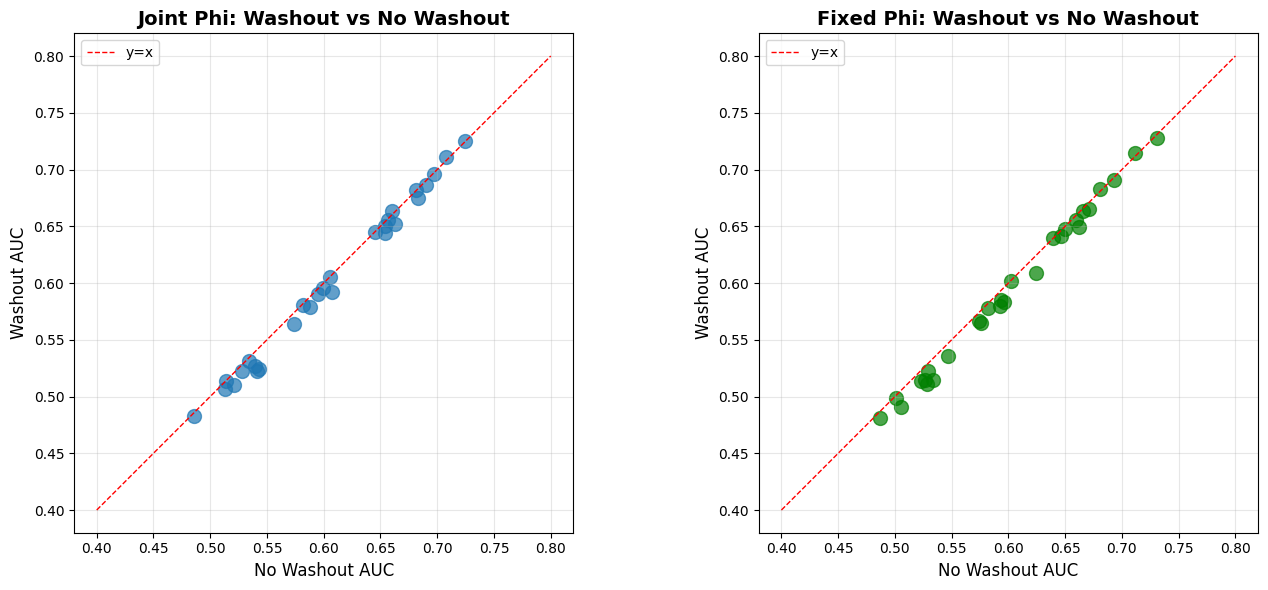

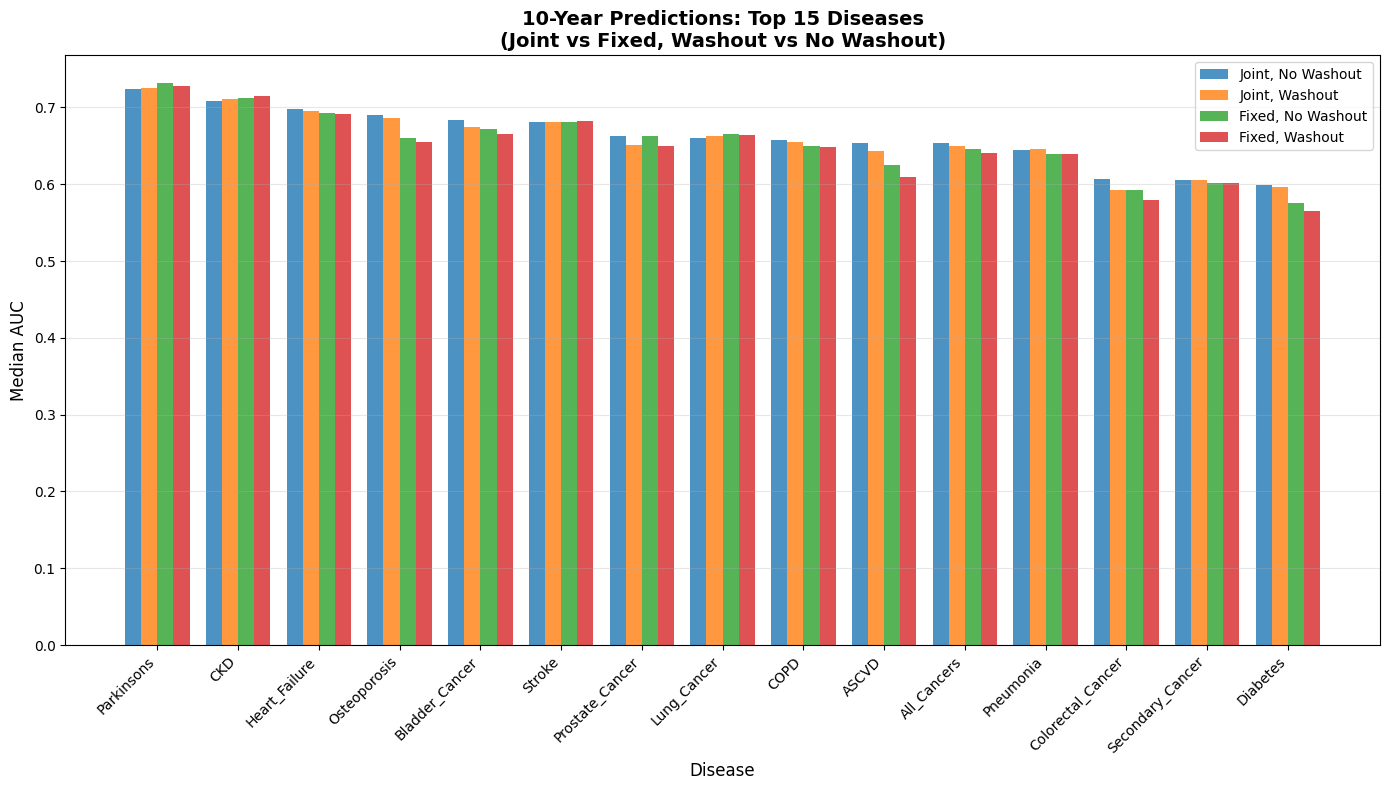

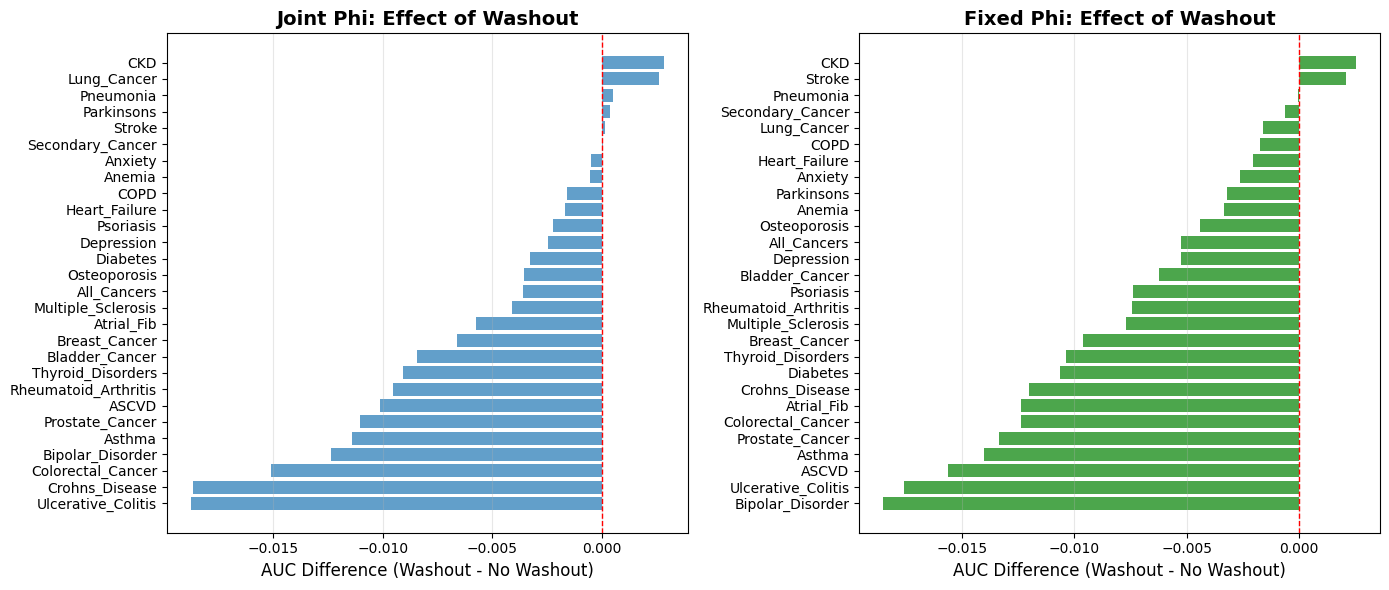


SUMMARY STATISTICS

Joint Phi - Washout Effect:
  Mean difference: -0.0055
  Median difference: -0.0036
  Std difference: 0.0061
  Range: [-0.0188, 0.0028]

Fixed Phi - Washout Effect:
  Mean difference: -0.0072
  Median difference: -0.0068
  Std difference: 0.0059
  Range: [-0.0185, 0.0025]

Joint vs Fixed (No Washout):
  Mean difference: 0.0056
  Median difference: 0.0051

Joint vs Fixed (Washout):
  Mean difference: 0.0073
  Median difference: 0.0068

✓ Visualizations saved!


In [106]:
# Compare 10-year predictions: Joint vs Fixed, Washout vs Non-Washout

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load all the CSV files
joint_10yr = pd.read_csv('joint_phi_10yr_median_auc.csv', index_col=0)
joint_10yr_washout = pd.read_csv('joint_phi_10yr_median_auc_washout.csv', index_col=0)
fixed_10yr = pd.read_csv('fixed_phi_10yr_median_auc.csv', index_col=0)
fixed_10yr_washout = pd.read_csv('fixed_phi_10yr_median_auc_washout.csv', index_col=0)

# Get common diseases across all datasets
all_diseases = set(joint_10yr.index) & set(joint_10yr_washout.index) & set(fixed_10yr.index) & set(fixed_10yr_washout.index)
diseases_sorted = sorted(list(all_diseases))

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Joint_NoWashout': joint_10yr.loc[diseases_sorted, 'median_auc'],
    'Joint_Washout': joint_10yr_washout.loc[diseases_sorted, 'median_auc'],
    'Fixed_NoWashout': fixed_10yr.loc[diseases_sorted, 'median_auc'],
    'Fixed_Washout': fixed_10yr_washout.loc[diseases_sorted, 'median_auc']
}, index=diseases_sorted)

# Calculate differences
comparison_df['Joint_Diff'] = comparison_df['Joint_Washout'] - comparison_df['Joint_NoWashout']
comparison_df['Fixed_Diff'] = comparison_df['Fixed_Washout'] - comparison_df['Fixed_NoWashout']
comparison_df['Joint_vs_Fixed_NoWashout'] = comparison_df['Joint_NoWashout'] - comparison_df['Fixed_NoWashout']
comparison_df['Joint_vs_Fixed_Washout'] = comparison_df['Joint_Washout'] - comparison_df['Fixed_Washout']

print("="*80)
print("10-YEAR PREDICTIONS COMPARISON TABLE")
print("="*80)
print(comparison_df.round(3))

# Save comparison table
comparison_df.to_csv('10yr_comparison_table.csv')
print("\n✓ Comparison table saved to '10yr_comparison_table.csv'")

# Visualization 1: Scatter plot - Washout vs No Washout
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Joint Phi
axes[0].scatter(comparison_df['Joint_NoWashout'], comparison_df['Joint_Washout'], alpha=0.7, s=100)
axes[0].plot([0.4, 0.8], [0.4, 0.8], 'r--', linewidth=1, label='y=x')
axes[0].set_xlabel('No Washout AUC', fontsize=12)
axes[0].set_ylabel('Washout AUC', fontsize=12)
axes[0].set_title('Joint Phi: Washout vs No Washout', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend()
axes[0].set_aspect('equal', adjustable='box')

# Fixed Phi
axes[1].scatter(comparison_df['Fixed_NoWashout'], comparison_df['Fixed_Washout'], alpha=0.7, s=100, color='green')
axes[1].plot([0.4, 0.8], [0.4, 0.8], 'r--', linewidth=1, label='y=x')
axes[1].set_xlabel('No Washout AUC', fontsize=12)
axes[1].set_ylabel('Washout AUC', fontsize=12)
axes[1].set_title('Fixed Phi: Washout vs No Washout', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend()
axes[1].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.savefig('washout_comparison_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

# Visualization 2: Grouped bar chart for top diseases
top_n = 15
top_diseases = comparison_df.nlargest(top_n, 'Joint_NoWashout').index

fig, ax = plt.subplots(figsize=(14, 8))
x = np.arange(len(top_diseases))
width = 0.2

bars1 = ax.bar(x - 1.5*width, comparison_df.loc[top_diseases, 'Joint_NoWashout'], width, 
               label='Joint, No Washout', alpha=0.8)
bars2 = ax.bar(x - 0.5*width, comparison_df.loc[top_diseases, 'Joint_Washout'], width, 
               label='Joint, Washout', alpha=0.8)
bars3 = ax.bar(x + 0.5*width, comparison_df.loc[top_diseases, 'Fixed_NoWashout'], width, 
               label='Fixed, No Washout', alpha=0.8)
bars4 = ax.bar(x + 1.5*width, comparison_df.loc[top_diseases, 'Fixed_Washout'], width, 
               label='Fixed, Washout', alpha=0.8)

ax.set_xlabel('Disease', fontsize=12)
ax.set_ylabel('Median AUC', fontsize=12)
ax.set_title(f'10-Year Predictions: Top {top_n} Diseases\n(Joint vs Fixed, Washout vs No Washout)', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(top_diseases, rotation=45, ha='right')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('10yr_comparison_barchart.png', dpi=300, bbox_inches='tight')
plt.show()

# Visualization 3: Difference plot (Washout - No Washout)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Joint Phi differences
joint_diffs = comparison_df['Joint_Diff'].sort_values()
axes[0].barh(range(len(joint_diffs)), joint_diffs.values, alpha=0.7)
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=1)
axes[0].set_yticks(range(len(joint_diffs)))
axes[0].set_yticklabels(joint_diffs.index)
axes[0].set_xlabel('AUC Difference (Washout - No Washout)', fontsize=12)
axes[0].set_title('Joint Phi: Effect of Washout', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')

# Fixed Phi differences
fixed_diffs = comparison_df['Fixed_Diff'].sort_values()
axes[1].barh(range(len(fixed_diffs)), fixed_diffs.values, alpha=0.7, color='green')
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=1)
axes[1].set_yticks(range(len(fixed_diffs)))
axes[1].set_yticklabels(fixed_diffs.index)
axes[1].set_xlabel('AUC Difference (Washout - No Washout)', fontsize=12)
axes[1].set_title('Fixed Phi: Effect of Washout', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('washout_differences.png', dpi=300, bbox_inches='tight')
plt.show()

# Summary statistics
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)
print(f"\nJoint Phi - Washout Effect:")
print(f"  Mean difference: {comparison_df['Joint_Diff'].mean():.4f}")
print(f"  Median difference: {comparison_df['Joint_Diff'].median():.4f}")
print(f"  Std difference: {comparison_df['Joint_Diff'].std():.4f}")
print(f"  Range: [{comparison_df['Joint_Diff'].min():.4f}, {comparison_df['Joint_Diff'].max():.4f}]")

print(f"\nFixed Phi - Washout Effect:")
print(f"  Mean difference: {comparison_df['Fixed_Diff'].mean():.4f}")
print(f"  Median difference: {comparison_df['Fixed_Diff'].median():.4f}")
print(f"  Std difference: {comparison_df['Fixed_Diff'].std():.4f}")
print(f"  Range: [{comparison_df['Fixed_Diff'].min():.4f}, {comparison_df['Fixed_Diff'].max():.4f}]")

print(f"\nJoint vs Fixed (No Washout):")
print(f"  Mean difference: {comparison_df['Joint_vs_Fixed_NoWashout'].mean():.4f}")
print(f"  Median difference: {comparison_df['Joint_vs_Fixed_NoWashout'].median():.4f}")

print(f"\nJoint vs Fixed (Washout):")
print(f"  Mean difference: {comparison_df['Joint_vs_Fixed_Washout'].mean():.4f}")
print(f"  Median difference: {comparison_df['Joint_vs_Fixed_Washout'].median():.4f}")

print("\n✓ Visualizations saved!")


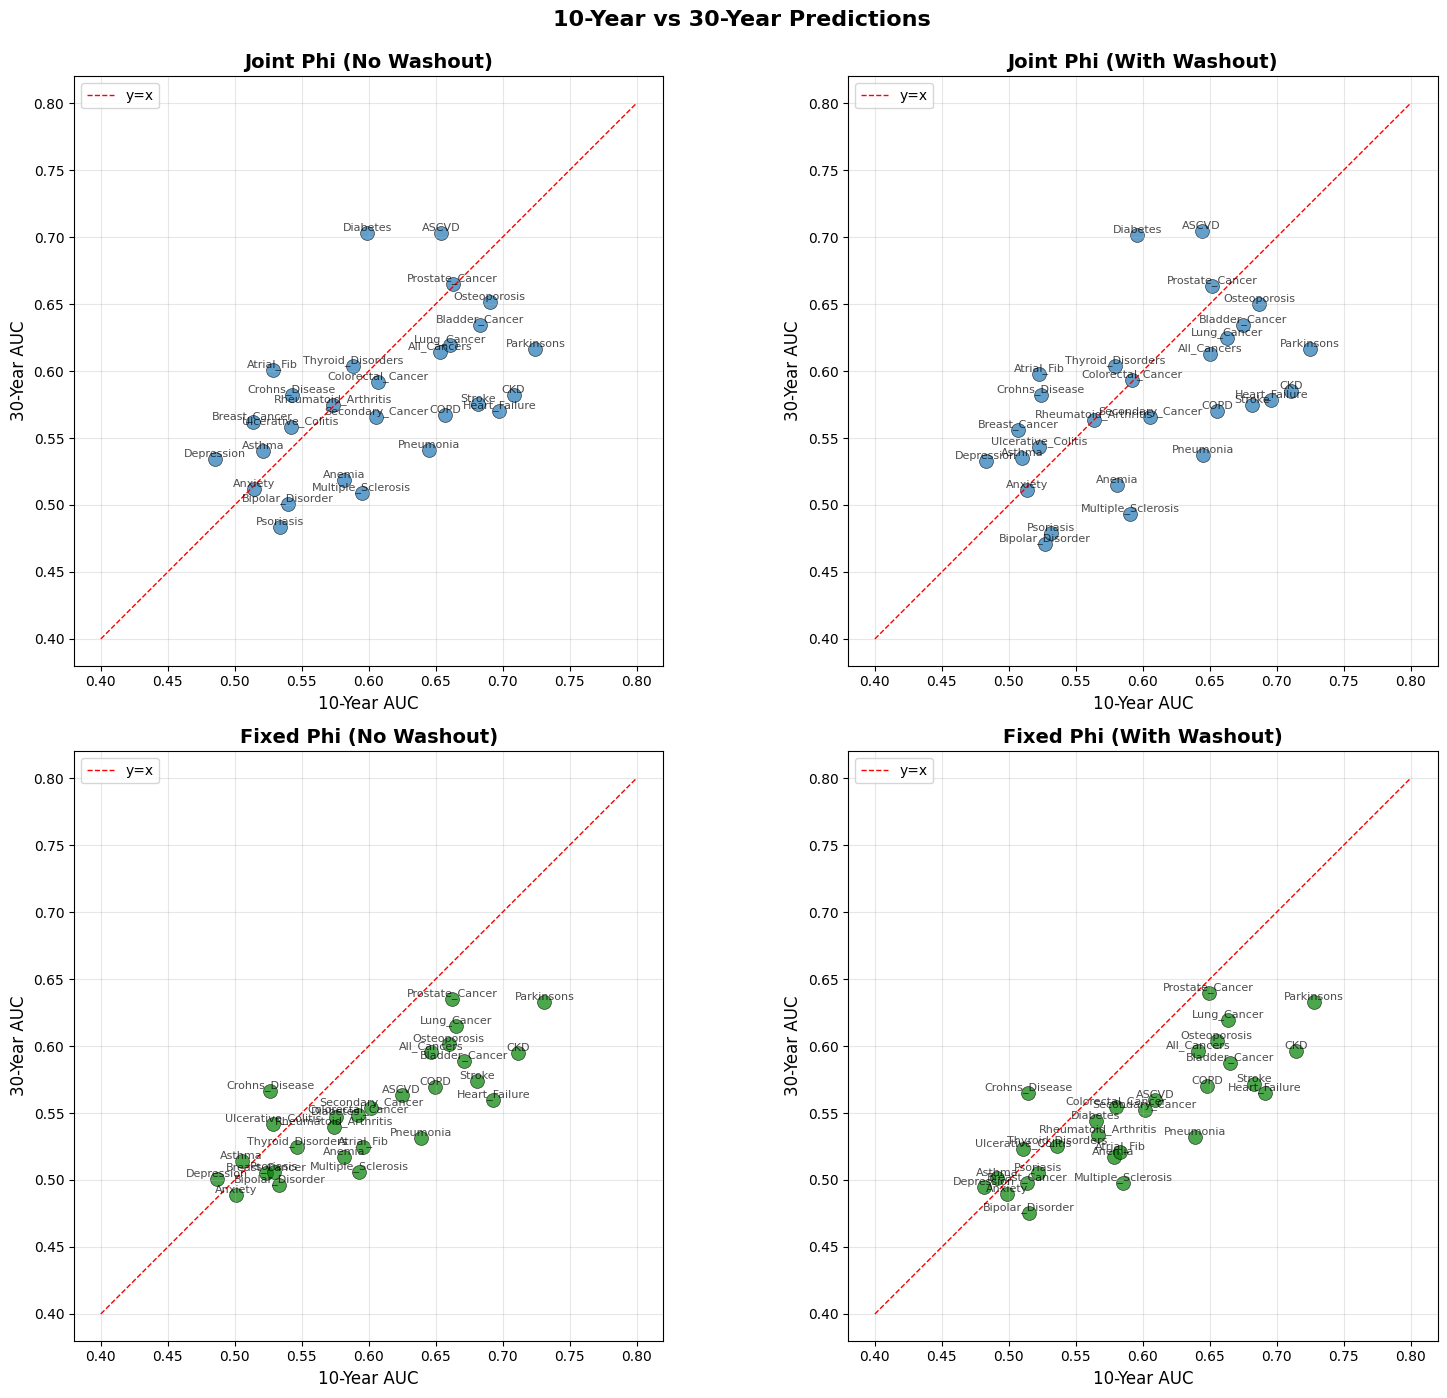

10-YEAR vs 30-YEAR CORRELATIONS

Joint Phi (No Washout): 0.524
Joint Phi (With Washout): 0.527
Fixed Phi (No Washout): 0.817
Fixed Phi (With Washout): 0.818

MEAN DIFFERENCES (30yr - 10yr)

Joint Phi (No Washout): -0.0252
Joint Phi (With Washout): -0.0228
Fixed Phi (No Washout): -0.0495
Fixed Phi (With Washout): -0.0449

✓ Plot saved as '10yr_vs_30yr_scatter_labeled.png'


In [108]:
# Compare 10-year vs 30-year predictions: Joint vs Fixed Phi (with disease labels)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load all CSV files
joint_10yr = pd.read_csv('joint_phi_10yr_median_auc.csv', index_col=0)
joint_30yr = pd.read_csv('joint_phi_30yr_median_auc.csv', index_col=0)
fixed_10yr = pd.read_csv('fixed_phi_10yr_median_auc.csv', index_col=0)
fixed_30yr = pd.read_csv('fixed_phi_30yr_median_auc.csv', index_col=0)

joint_10yr_washout = pd.read_csv('joint_phi_10yr_median_auc_washout.csv', index_col=0)
joint_30yr_washout = pd.read_csv('joint_phi_30yr_median_auc_washout.csv', index_col=0)
fixed_10yr_washout = pd.read_csv('fixed_phi_10yr_median_auc_washout.csv', index_col=0)
fixed_30yr_washout = pd.read_csv('fixed_phi_30yr_median_auc_washout.csv', index_col=0)

# Get common diseases
all_diseases = set(joint_10yr.index) & set(joint_30yr.index) & set(fixed_10yr.index) & set(fixed_30yr.index)
diseases_sorted = sorted(list(all_diseases))

# Create figure with 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Joint Phi - No Washout
x_vals = joint_10yr.loc[diseases_sorted, 'median_auc']
y_vals = joint_30yr.loc[diseases_sorted, 'median_auc']
axes[0, 0].scatter(x_vals, y_vals, alpha=0.7, s=100, edgecolors='black', linewidth=0.5)
for disease in diseases_sorted:
    axes[0, 0].annotate(disease, 
                        (joint_10yr.loc[disease, 'median_auc'], joint_30yr.loc[disease, 'median_auc']),
                        fontsize=8, alpha=0.7, ha='center', va='bottom')
axes[0, 0].plot([0.4, 0.8], [0.4, 0.8], 'r--', linewidth=1, label='y=x')
axes[0, 0].set_xlabel('10-Year AUC', fontsize=12)
axes[0, 0].set_ylabel('30-Year AUC', fontsize=12)
axes[0, 0].set_title('Joint Phi (No Washout)', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()
axes[0, 0].set_aspect('equal', adjustable='box')

# Joint Phi - With Washout
x_vals = joint_10yr_washout.loc[diseases_sorted, 'median_auc']
y_vals = joint_30yr_washout.loc[diseases_sorted, 'median_auc']
axes[0, 1].scatter(x_vals, y_vals, alpha=0.7, s=100, edgecolors='black', linewidth=0.5)
for disease in diseases_sorted:
    axes[0, 1].annotate(disease, 
                        (joint_10yr_washout.loc[disease, 'median_auc'], joint_30yr_washout.loc[disease, 'median_auc']),
                        fontsize=8, alpha=0.7, ha='center', va='bottom')
axes[0, 1].plot([0.4, 0.8], [0.4, 0.8], 'r--', linewidth=1, label='y=x')
axes[0, 1].set_xlabel('10-Year AUC', fontsize=12)
axes[0, 1].set_ylabel('30-Year AUC', fontsize=12)
axes[0, 1].set_title('Joint Phi (With Washout)', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()
axes[0, 1].set_aspect('equal', adjustable='box')

# Fixed Phi - No Washout
x_vals = fixed_10yr.loc[diseases_sorted, 'median_auc']
y_vals = fixed_30yr.loc[diseases_sorted, 'median_auc']
axes[1, 0].scatter(x_vals, y_vals, alpha=0.7, s=100, color='green', edgecolors='black', linewidth=0.5)
for disease in diseases_sorted:
    axes[1, 0].annotate(disease, 
                        (fixed_10yr.loc[disease, 'median_auc'], fixed_30yr.loc[disease, 'median_auc']),
                        fontsize=8, alpha=0.7, ha='center', va='bottom')
axes[1, 0].plot([0.4, 0.8], [0.4, 0.8], 'r--', linewidth=1, label='y=x')
axes[1, 0].set_xlabel('10-Year AUC', fontsize=12)
axes[1, 0].set_ylabel('30-Year AUC', fontsize=12)
axes[1, 0].set_title('Fixed Phi (No Washout)', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()
axes[1, 0].set_aspect('equal', adjustable='box')

# Fixed Phi - With Washout
x_vals = fixed_10yr_washout.loc[diseases_sorted, 'median_auc']
y_vals = fixed_30yr_washout.loc[diseases_sorted, 'median_auc']
axes[1, 1].scatter(x_vals, y_vals, alpha=0.7, s=100, color='green', edgecolors='black', linewidth=0.5)
for disease in diseases_sorted:
    axes[1, 1].annotate(disease, 
                        (fixed_10yr_washout.loc[disease, 'median_auc'], fixed_30yr_washout.loc[disease, 'median_auc']),
                        fontsize=8, alpha=0.7, ha='center', va='bottom')
axes[1, 1].plot([0.4, 0.8], [0.4, 0.8], 'r--', linewidth=1, label='y=x')
axes[1, 1].set_xlabel('10-Year AUC', fontsize=12)
axes[1, 1].set_ylabel('30-Year AUC', fontsize=12)
axes[1, 1].set_title('Fixed Phi (With Washout)', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend()
axes[1, 1].set_aspect('equal', adjustable='box')

plt.suptitle('10-Year vs 30-Year Predictions', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('10yr_vs_30yr_scatter_labeled.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate correlations
print("="*80)
print("10-YEAR vs 30-YEAR CORRELATIONS")
print("="*80)
print(f"\nJoint Phi (No Washout): {np.corrcoef(joint_10yr.loc[diseases_sorted, 'median_auc'], joint_30yr.loc[diseases_sorted, 'median_auc'])[0,1]:.3f}")
print(f"Joint Phi (With Washout): {np.corrcoef(joint_10yr_washout.loc[diseases_sorted, 'median_auc'], joint_30yr_washout.loc[diseases_sorted, 'median_auc'])[0,1]:.3f}")
print(f"Fixed Phi (No Washout): {np.corrcoef(fixed_10yr.loc[diseases_sorted, 'median_auc'], fixed_30yr.loc[diseases_sorted, 'median_auc'])[0,1]:.3f}")
print(f"Fixed Phi (With Washout): {np.corrcoef(fixed_10yr_washout.loc[diseases_sorted, 'median_auc'], fixed_30yr_washout.loc[diseases_sorted, 'median_auc'])[0,1]:.3f}")

# Calculate mean differences
print("\n" + "="*80)
print("MEAN DIFFERENCES (30yr - 10yr)")
print("="*80)
joint_diff_nowash = (joint_30yr.loc[diseases_sorted, 'median_auc'] - joint_10yr.loc[diseases_sorted, 'median_auc']).mean()
joint_diff_wash = (joint_30yr_washout.loc[diseases_sorted, 'median_auc'] - joint_10yr_washout.loc[diseases_sorted, 'median_auc']).mean()
fixed_diff_nowash = (fixed_30yr.loc[diseases_sorted, 'median_auc'] - fixed_10yr.loc[diseases_sorted, 'median_auc']).mean()
fixed_diff_wash = (fixed_30yr_washout.loc[diseases_sorted, 'median_auc'] - fixed_10yr_washout.loc[diseases_sorted, 'median_auc']).mean()

print(f"\nJoint Phi (No Washout): {joint_diff_nowash:.4f}")
print(f"Joint Phi (With Washout): {joint_diff_wash:.4f}")
print(f"Fixed Phi (No Washout): {fixed_diff_nowash:.4f}")
print(f"Fixed Phi (With Washout): {fixed_diff_wash:.4f}")

print("\n✓ Plot saved as '10yr_vs_30yr_scatter_labeled.png'")

In [109]:
# Aggregate bootstrap CIs across batches
# Option 1: Use existing ci_lower and ci_upper (median across batches)

def compute_aggregated_cis(results_list, name=""):
    """Extract CI bounds and aggregate across batches"""
    if not results_list:
        return pd.DataFrame()
    
    # Get all disease names
    disease_names_list = [k for k in results_list[0].keys() if k != 'batch_idx']
    
    ci_data = {disease: {'ci_lowers': [], 'ci_uppers': [], 'aucs': []} 
               for disease in disease_names_list}
    
    for result in results_list:
        for disease in disease_names_list:
            if disease in result:
                if isinstance(result[disease], dict):
                    if 'ci_lower' in result[disease] and not np.isnan(result[disease]['ci_lower']):
                        ci_data[disease]['ci_lowers'].append(result[disease]['ci_lower'])
                    if 'ci_upper' in result[disease] and not np.isnan(result[disease]['ci_upper']):
                        ci_data[disease]['ci_uppers'].append(result[disease]['ci_upper'])
                    if 'auc' in result[disease] and not np.isnan(result[disease]['auc']):
                        ci_data[disease]['aucs'].append(result[disease]['auc'])
    
    # Aggregate: median of bounds and median AUC
    aggregated = {}
    for disease in disease_names_list:
        if ci_data[disease]['aucs']:
            aggregated[disease] = {
                'median_auc': np.median(ci_data[disease]['aucs']),
                'ci_lower_median': np.median(ci_data[disease]['ci_lowers']) if ci_data[disease]['ci_lowers'] else np.nan,
                'ci_upper_median': np.median(ci_data[disease]['ci_uppers']) if ci_data[disease]['ci_uppers'] else np.nan,
                'ci_lower_min': np.min(ci_data[disease]['ci_lowers']) if ci_data[disease]['ci_lowers'] else np.nan,
                'ci_upper_max': np.max(ci_data[disease]['ci_uppers']) if ci_data[disease]['ci_uppers'] else np.nan,
                'n_batches': len(ci_data[disease]['aucs'])
            }
        else:
            aggregated[disease] = {
                'median_auc': np.nan,
                'ci_lower_median': np.nan,
                'ci_upper_median': np.nan,
                'ci_lower_min': np.nan,
                'ci_upper_max': np.nan,
                'n_batches': 0
            }
    
    df = pd.DataFrame(aggregated).T
    df = df.sort_values('median_auc', ascending=False)
    
    return df

# Compute aggregated CIs for all result sets
print("="*80)
print("AGGREGATING BOOTSTRAP CIs ACROSS BATCHES")
print("="*80)

joint_10yr_aggregated = compute_aggregated_cis(joint_10yr_results, "Joint 10yr")
joint_30yr_aggregated = compute_aggregated_cis(joint_30yr_results, "Joint 30yr")
fixed_10yr_aggregated = compute_aggregated_cis(fixed_10yr_results, "Fixed 10yr")
fixed_30yr_aggregated = compute_aggregated_cis(fixed_30yr_results, "Fixed 30yr")

joint_10yr_washout_aggregated = compute_aggregated_cis(joint_10yr_results_washout, "Joint 10yr Washout")
joint_30yr_washout_aggregated = compute_aggregated_cis(joint_30yr_results_washout, "Joint 30yr Washout")
fixed_10yr_washout_aggregated = compute_aggregated_cis(fixed_10yr_results_washout, "Fixed 10yr Washout")
fixed_30yr_washout_aggregated = compute_aggregated_cis(fixed_30yr_results_washout, "Fixed 30yr Washout")

# Display
print("\nJoint Phi - 10yr (No Washout):")
print(joint_10yr_aggregated[['median_auc', 'ci_lower_median', 'ci_upper_median', 'n_batches']].round(3))

print("\nJoint Phi - 10yr (With Washout):")
print(joint_10yr_washout_aggregated[['median_auc', 'ci_lower_median', 'ci_upper_median', 'n_batches']].round(3))

# Save aggregated results
joint_10yr_aggregated.to_csv('joint_phi_10yr_aggregated_cis.csv')
joint_30yr_aggregated.to_csv('joint_phi_30yr_aggregated_cis.csv')
fixed_10yr_aggregated.to_csv('fixed_phi_10yr_aggregated_cis.csv')
fixed_30yr_aggregated.to_csv('fixed_phi_30yr_aggregated_cis.csv')

joint_10yr_washout_aggregated.to_csv('joint_phi_10yr_washout_aggregated_cis.csv')
joint_30yr_washout_aggregated.to_csv('joint_phi_30yr_washout_aggregated_cis.csv')
fixed_10yr_washout_aggregated.to_csv('fixed_phi_10yr_washout_aggregated_cis.csv')
fixed_30yr_washout_aggregated.to_csv('fixed_phi_30yr_washout_aggregated_cis.csv')

print("\n✓ Aggregated CI results saved to CSV files")

AGGREGATING BOOTSTRAP CIs ACROSS BATCHES

Joint Phi - 10yr (No Washout):
                      median_auc  ci_lower_median  ci_upper_median  n_batches
Parkinsons                 0.724            0.664            0.786       40.0
CKD                        0.708            0.676            0.740       40.0
Heart_Failure              0.698            0.665            0.728       40.0
Osteoporosis               0.690            0.659            0.724       40.0
Bladder_Cancer             0.683            0.624            0.746       40.0
Stroke                     0.681            0.639            0.722       40.0
Prostate_Cancer            0.663            0.630            0.696       40.0
Lung_Cancer                0.660            0.614            0.715       40.0
COPD                       0.657            0.633            0.680       40.0
ASCVD                      0.654            0.636            0.672       40.0
All_Cancers                0.654            0.634            0.674   

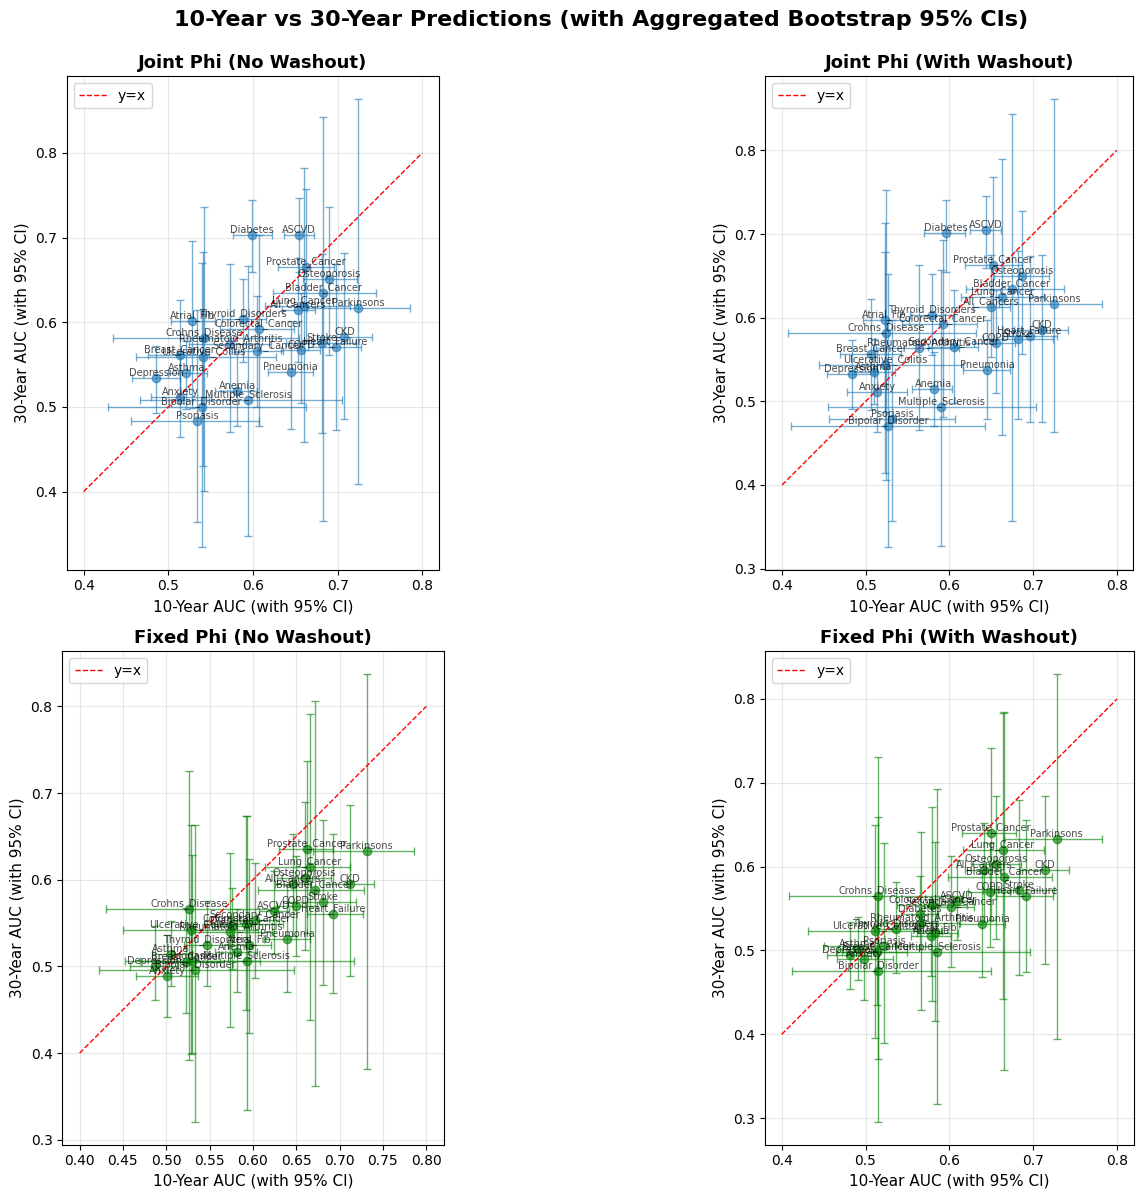

✓ Plot with CI error bars saved!


In [110]:
# Plot median AUCs with aggregated bootstrap CI intervals
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load aggregated CI results (or compute them if not already done)
# Assuming we have the aggregated results...

# If aggregated results not computed yet, compute them
def compute_aggregated_cis(results_list):
    """Extract CI bounds and aggregate across batches"""
    if not results_list:
        return pd.DataFrame()
    
    disease_names_list = [k for k in results_list[0].keys() if k != 'batch_idx']
    
    ci_data = {disease: {'ci_lowers': [], 'ci_uppers': [], 'aucs': []} 
               for disease in disease_names_list}
    
    for result in results_list:
        for disease in disease_names_list:
            if disease in result and isinstance(result[disease], dict):
                if 'ci_lower' in result[disease] and not np.isnan(result[disease]['ci_lower']):
                    ci_data[disease]['ci_lowers'].append(result[disease]['ci_lower'])
                if 'ci_upper' in result[disease] and not np.isnan(result[disease]['ci_upper']):
                    ci_data[disease]['ci_uppers'].append(result[disease]['ci_upper'])
                if 'auc' in result[disease] and not np.isnan(result[disease]['auc']):
                    ci_data[disease]['aucs'].append(result[disease]['auc'])
    
    aggregated = {}
    for disease in disease_names_list:
        if ci_data[disease]['aucs']:
            aggregated[disease] = {
                'median_auc': np.median(ci_data[disease]['aucs']),
                'ci_lower_median': np.median(ci_data[disease]['ci_lowers']) if ci_data[disease]['ci_lowers'] else np.nan,
                'ci_upper_median': np.median(ci_data[disease]['ci_uppers']) if ci_data[disease]['ci_uppers'] else np.nan,
                'n_batches': len(ci_data[disease]['aucs'])
            }
        else:
            aggregated[disease] = {
                'median_auc': np.nan,
                'ci_lower_median': np.nan,
                'ci_upper_median': np.nan,
                'n_batches': 0
            }
    
    df = pd.DataFrame(aggregated).T
    df = df.sort_values('median_auc', ascending=False)
    return df

# Compute aggregated CIs
joint_10yr_agg = compute_aggregated_cis(joint_10yr_results)
joint_30yr_agg = compute_aggregated_cis(joint_30yr_results)
fixed_10yr_agg = compute_aggregated_cis(fixed_10yr_results)
fixed_30yr_agg = compute_aggregated_cis(fixed_30yr_results)

joint_10yr_washout_agg = compute_aggregated_cis(joint_10yr_results_washout)
joint_30yr_washout_agg = compute_aggregated_cis(joint_30yr_results_washout)
fixed_10yr_washout_agg = compute_aggregated_cis(fixed_10yr_results_washout)
fixed_30yr_washout_agg = compute_aggregated_cis(fixed_30yr_results_washout)

# Get common diseases
all_diseases = set(joint_10yr_agg.index) & set(joint_30yr_agg.index) & set(fixed_10yr_agg.index) & set(fixed_30yr_agg.index)
diseases_sorted = sorted(list(all_diseases))

# Create comparison plot with error bars
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Joint Phi - No Washout
x_pos = np.arange(len(diseases_sorted))
medians_10 = joint_10yr_agg.loc[diseases_sorted, 'median_auc'].values
medians_30 = joint_30yr_agg.loc[diseases_sorted, 'median_auc'].values
lower_err_10 = (medians_10 - joint_10yr_agg.loc[diseases_sorted, 'ci_lower_median'].values)
upper_err_10 = (joint_10yr_agg.loc[diseases_sorted, 'ci_upper_median'].values - medians_10)
lower_err_30 = (medians_30 - joint_30yr_agg.loc[diseases_sorted, 'ci_lower_median'].values)
upper_err_30 = (joint_30yr_agg.loc[diseases_sorted, 'ci_upper_median'].values - medians_30)

axes[0, 0].errorbar(medians_10, medians_30, 
                    xerr=[lower_err_10, upper_err_10], 
                    yerr=[lower_err_30, upper_err_30],
                    fmt='o', alpha=0.6, capsize=3, capthick=1, elinewidth=1)
for i, disease in enumerate(diseases_sorted):
    axes[0, 0].annotate(disease, (medians_10[i], medians_30[i]),
                       fontsize=7, alpha=0.7, ha='center', va='bottom')
axes[0, 0].plot([0.4, 0.8], [0.4, 0.8], 'r--', linewidth=1, label='y=x')
axes[0, 0].set_xlabel('10-Year AUC (with 95% CI)', fontsize=11)
axes[0, 0].set_ylabel('30-Year AUC (with 95% CI)', fontsize=11)
axes[0, 0].set_title('Joint Phi (No Washout)', fontsize=13, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()
axes[0, 0].set_aspect('equal', adjustable='box')

# Joint Phi - With Washout
medians_10_w = joint_10yr_washout_agg.loc[diseases_sorted, 'median_auc'].values
medians_30_w = joint_30yr_washout_agg.loc[diseases_sorted, 'median_auc'].values
lower_err_10_w = (medians_10_w - joint_10yr_washout_agg.loc[diseases_sorted, 'ci_lower_median'].values)
upper_err_10_w = (joint_10yr_washout_agg.loc[diseases_sorted, 'ci_upper_median'].values - medians_10_w)
lower_err_30_w = (medians_30_w - joint_30yr_washout_agg.loc[diseases_sorted, 'ci_lower_median'].values)
upper_err_30_w = (joint_30yr_washout_agg.loc[diseases_sorted, 'ci_upper_median'].values - medians_30_w)

axes[0, 1].errorbar(medians_10_w, medians_30_w,
                    xerr=[lower_err_10_w, upper_err_10_w],
                    yerr=[lower_err_30_w, upper_err_30_w],
                    fmt='o', alpha=0.6, capsize=3, capthick=1, elinewidth=1)
for i, disease in enumerate(diseases_sorted):
    axes[0, 1].annotate(disease, (medians_10_w[i], medians_30_w[i]),
                       fontsize=7, alpha=0.7, ha='center', va='bottom')
axes[0, 1].plot([0.4, 0.8], [0.4, 0.8], 'r--', linewidth=1, label='y=x')
axes[0, 1].set_xlabel('10-Year AUC (with 95% CI)', fontsize=11)
axes[0, 1].set_ylabel('30-Year AUC (with 95% CI)', fontsize=11)
axes[0, 1].set_title('Joint Phi (With Washout)', fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()
axes[0, 1].set_aspect('equal', adjustable='box')

# Fixed Phi - No Washout
medians_10_f = fixed_10yr_agg.loc[diseases_sorted, 'median_auc'].values
medians_30_f = fixed_30yr_agg.loc[diseases_sorted, 'median_auc'].values
lower_err_10_f = (medians_10_f - fixed_10yr_agg.loc[diseases_sorted, 'ci_lower_median'].values)
upper_err_10_f = (fixed_10yr_agg.loc[diseases_sorted, 'ci_upper_median'].values - medians_10_f)
lower_err_30_f = (medians_30_f - fixed_30yr_agg.loc[diseases_sorted, 'ci_lower_median'].values)
upper_err_30_f = (fixed_30yr_agg.loc[diseases_sorted, 'ci_upper_median'].values - medians_30_f)

axes[1, 0].errorbar(medians_10_f, medians_30_f,
                    xerr=[lower_err_10_f, upper_err_10_f],
                    yerr=[lower_err_30_f, upper_err_30_f],
                    fmt='o', alpha=0.6, capsize=3, capthick=1, elinewidth=1, color='green')
for i, disease in enumerate(diseases_sorted):
    axes[1, 0].annotate(disease, (medians_10_f[i], medians_30_f[i]),
                       fontsize=7, alpha=0.7, ha='center', va='bottom')
axes[1, 0].plot([0.4, 0.8], [0.4, 0.8], 'r--', linewidth=1, label='y=x')
axes[1, 0].set_xlabel('10-Year AUC (with 95% CI)', fontsize=11)
axes[1, 0].set_ylabel('30-Year AUC (with 95% CI)', fontsize=11)
axes[1, 0].set_title('Fixed Phi (No Washout)', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()
axes[1, 0].set_aspect('equal', adjustable='box')

# Fixed Phi - With Washout
medians_10_fw = fixed_10yr_washout_agg.loc[diseases_sorted, 'median_auc'].values
medians_30_fw = fixed_30yr_washout_agg.loc[diseases_sorted, 'median_auc'].values
lower_err_10_fw = (medians_10_fw - fixed_10yr_washout_agg.loc[diseases_sorted, 'ci_lower_median'].values)
upper_err_10_fw = (fixed_10yr_washout_agg.loc[diseases_sorted, 'ci_upper_median'].values - medians_10_fw)
lower_err_30_fw = (medians_30_fw - fixed_30yr_washout_agg.loc[diseases_sorted, 'ci_lower_median'].values)
upper_err_30_fw = (fixed_30yr_washout_agg.loc[diseases_sorted, 'ci_upper_median'].values - medians_30_fw)

axes[1, 1].errorbar(medians_10_fw, medians_30_fw,
                    xerr=[lower_err_10_fw, upper_err_10_fw],
                    yerr=[lower_err_30_fw, upper_err_30_fw],
                    fmt='o', alpha=0.6, capsize=3, capthick=1, elinewidth=1, color='green')
for i, disease in enumerate(diseases_sorted):
    axes[1, 1].annotate(disease, (medians_10_fw[i], medians_30_fw[i]),
                       fontsize=7, alpha=0.7, ha='center', va='bottom')
axes[1, 1].plot([0.4, 0.8], [0.4, 0.8], 'r--', linewidth=1, label='y=x')
axes[1, 1].set_xlabel('10-Year AUC (with 95% CI)', fontsize=11)
axes[1, 1].set_ylabel('30-Year AUC (with 95% CI)', fontsize=11)
axes[1, 1].set_title('Fixed Phi (With Washout)', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend()
axes[1, 1].set_aspect('equal', adjustable='box')

plt.suptitle('10-Year vs 30-Year Predictions (with Aggregated Bootstrap 95% CIs)', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('10yr_vs_30yr_with_ci_errorbars.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Plot with CI error bars saved!")

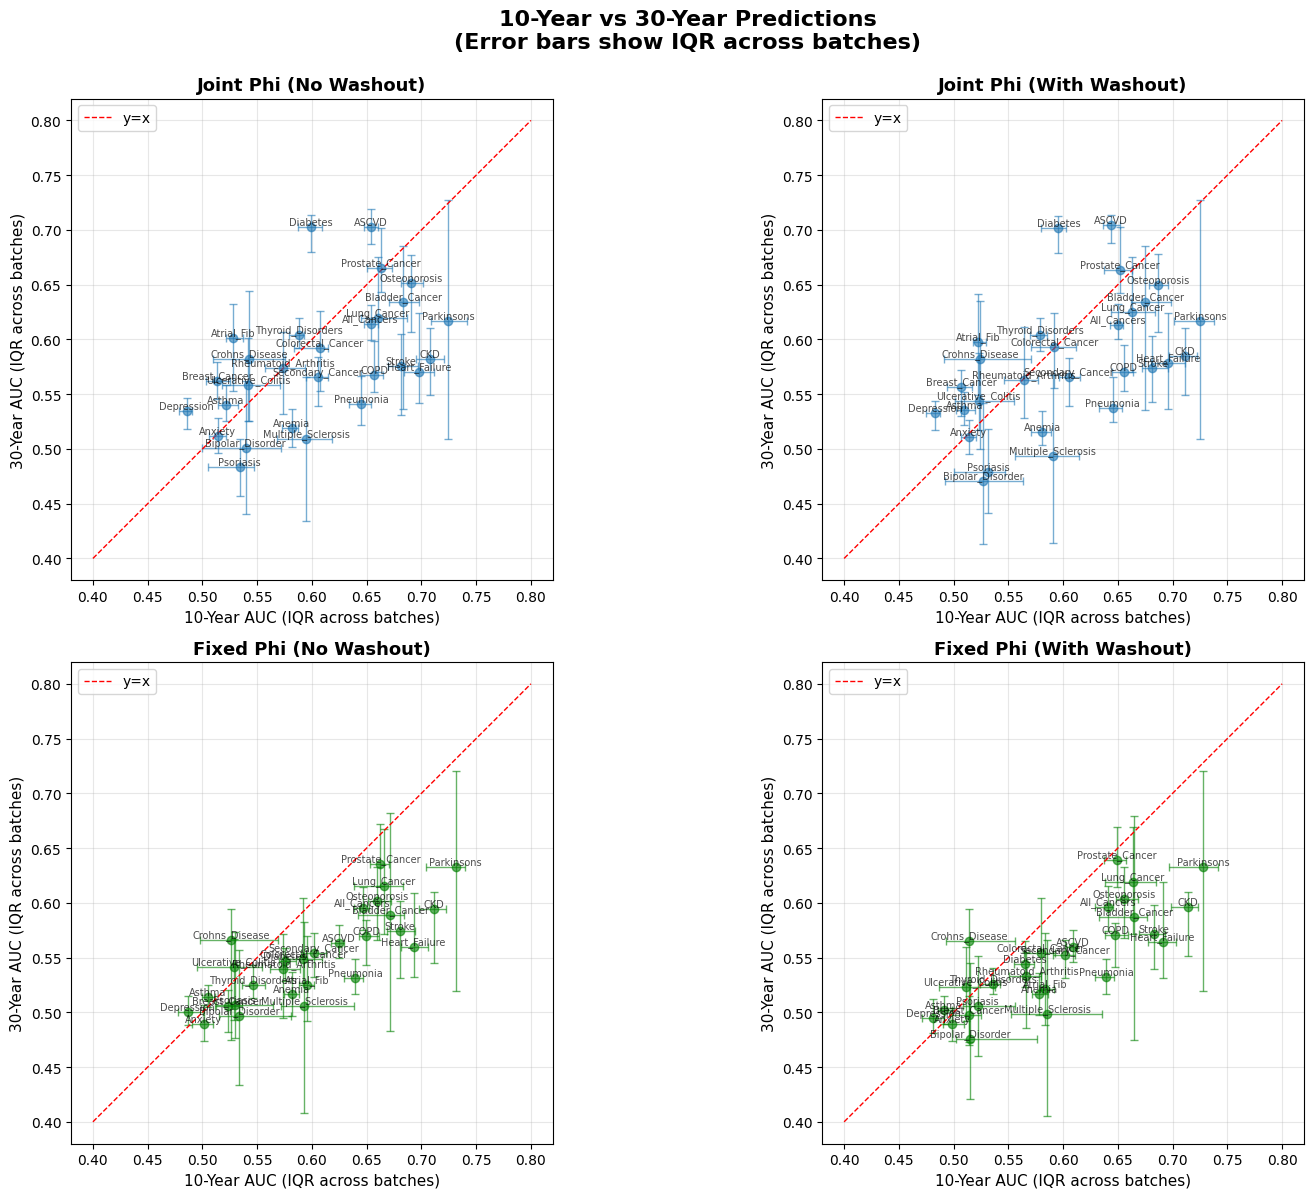

✓ Plot with IQR error bars saved!


In [111]:
# Plot with IQR across batches (between-batch variation) instead of aggregated bootstrap CIs

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def compute_median_and_iqr(results_list):
    """Compute median AUC and IQR across batches"""
    if not results_list:
        return pd.DataFrame()
    
    disease_names_list = [k for k in results_list[0].keys() if k != 'batch_idx']
    
    auc_data = {disease: [] for disease in disease_names_list}
    
    for result in results_list:
        for disease in disease_names_list:
            if disease in result and isinstance(result[disease], dict):
                if 'auc' in result[disease] and not np.isnan(result[disease]['auc']):
                    auc_data[disease].append(result[disease]['auc'])
    
    aggregated = {}
    for disease in disease_names_list:
        if auc_data[disease]:
            aucs = np.array(auc_data[disease])
            aggregated[disease] = {
                'median_auc': np.median(aucs),
                'q25': np.percentile(aucs, 25),
                'q75': np.percentile(aucs, 75),
                'iqr': np.percentile(aucs, 75) - np.percentile(aucs, 25),
                'min': np.min(aucs),
                'max': np.max(aucs),
                'n_batches': len(aucs)
            }
        else:
            aggregated[disease] = {
                'median_auc': np.nan,
                'q25': np.nan,
                'q75': np.nan,
                'iqr': np.nan,
                'min': np.nan,
                'max': np.nan,
                'n_batches': 0
            }
    
    df = pd.DataFrame(aggregated).T
    df = df.sort_values('median_auc', ascending=False)
    return df

# Compute median and IQR for all result sets
joint_10yr_stats = compute_median_and_iqr(joint_10yr_results)
joint_30yr_stats = compute_median_and_iqr(joint_30yr_results)
fixed_10yr_stats = compute_median_and_iqr(fixed_10yr_results)
fixed_30yr_stats = compute_median_and_iqr(fixed_30yr_results)

joint_10yr_washout_stats = compute_median_and_iqr(joint_10yr_results_washout)
joint_30yr_washout_stats = compute_median_and_iqr(joint_30yr_results_washout)
fixed_10yr_washout_stats = compute_median_and_iqr(fixed_10yr_results_washout)
fixed_30yr_washout_stats = compute_median_and_iqr(fixed_30yr_results_washout)

# Get common diseases
all_diseases = set(joint_10yr_stats.index) & set(joint_30yr_stats.index) & set(fixed_10yr_stats.index) & set(fixed_30yr_stats.index)
diseases_sorted = sorted(list(all_diseases))

# Create figure with 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Joint Phi - No Washout (using IQR)
medians_10 = joint_10yr_stats.loc[diseases_sorted, 'median_auc'].values
medians_30 = joint_30yr_stats.loc[diseases_sorted, 'median_auc'].values
lower_err_10 = (medians_10 - joint_10yr_stats.loc[diseases_sorted, 'q25'].values)
upper_err_10 = (joint_10yr_stats.loc[diseases_sorted, 'q75'].values - medians_10)
lower_err_30 = (medians_30 - joint_30yr_stats.loc[diseases_sorted, 'q25'].values)
upper_err_30 = (joint_30yr_stats.loc[diseases_sorted, 'q75'].values - medians_30)

axes[0, 0].errorbar(medians_10, medians_30, 
                    xerr=[lower_err_10, upper_err_10], 
                    yerr=[lower_err_30, upper_err_30],
                    fmt='o', alpha=0.6, capsize=3, capthick=1, elinewidth=1)
for i, disease in enumerate(diseases_sorted):
    axes[0, 0].annotate(disease, (medians_10[i], medians_30[i]),
                       fontsize=7, alpha=0.7, ha='center', va='bottom')
axes[0, 0].plot([0.4, 0.8], [0.4, 0.8], 'r--', linewidth=1, label='y=x')
axes[0, 0].set_xlabel('10-Year AUC (IQR across batches)', fontsize=11)
axes[0, 0].set_ylabel('30-Year AUC (IQR across batches)', fontsize=11)
axes[0, 0].set_title('Joint Phi (No Washout)', fontsize=13, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()
axes[0, 0].set_aspect('equal', adjustable='box')

# Joint Phi - With Washout
medians_10_w = joint_10yr_washout_stats.loc[diseases_sorted, 'median_auc'].values
medians_30_w = joint_30yr_washout_stats.loc[diseases_sorted, 'median_auc'].values
lower_err_10_w = (medians_10_w - joint_10yr_washout_stats.loc[diseases_sorted, 'q25'].values)
upper_err_10_w = (joint_10yr_washout_stats.loc[diseases_sorted, 'q75'].values - medians_10_w)
lower_err_30_w = (medians_30_w - joint_30yr_washout_stats.loc[diseases_sorted, 'q25'].values)
upper_err_30_w = (joint_30yr_washout_stats.loc[diseases_sorted, 'q75'].values - medians_30_w)

axes[0, 1].errorbar(medians_10_w, medians_30_w,
                    xerr=[lower_err_10_w, upper_err_10_w],
                    yerr=[lower_err_30_w, upper_err_30_w],
                    fmt='o', alpha=0.6, capsize=3, capthick=1, elinewidth=1)
for i, disease in enumerate(diseases_sorted):
    axes[0, 1].annotate(disease, (medians_10_w[i], medians_30_w[i]),
                       fontsize=7, alpha=0.7, ha='center', va='bottom')
axes[0, 1].plot([0.4, 0.8], [0.4, 0.8], 'r--', linewidth=1, label='y=x')
axes[0, 1].set_xlabel('10-Year AUC (IQR across batches)', fontsize=11)
axes[0, 1].set_ylabel('30-Year AUC (IQR across batches)', fontsize=11)
axes[0, 1].set_title('Joint Phi (With Washout)', fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()
axes[0, 1].set_aspect('equal', adjustable='box')

# Fixed Phi - No Washout
medians_10_f = fixed_10yr_stats.loc[diseases_sorted, 'median_auc'].values
medians_30_f = fixed_30yr_stats.loc[diseases_sorted, 'median_auc'].values
lower_err_10_f = (medians_10_f - fixed_10yr_stats.loc[diseases_sorted, 'q25'].values)
upper_err_10_f = (fixed_10yr_stats.loc[diseases_sorted, 'q75'].values - medians_10_f)
lower_err_30_f = (medians_30_f - fixed_30yr_stats.loc[diseases_sorted, 'q25'].values)
upper_err_30_f = (fixed_30yr_stats.loc[diseases_sorted, 'q75'].values - medians_30_f)

axes[1, 0].errorbar(medians_10_f, medians_30_f,
                    xerr=[lower_err_10_f, upper_err_10_f],
                    yerr=[lower_err_30_f, upper_err_30_f],
                    fmt='o', alpha=0.6, capsize=3, capthick=1, elinewidth=1, color='green')
for i, disease in enumerate(diseases_sorted):
    axes[1, 0].annotate(disease, (medians_10_f[i], medians_30_f[i]),
                       fontsize=7, alpha=0.7, ha='center', va='bottom')
axes[1, 0].plot([0.4, 0.8], [0.4, 0.8], 'r--', linewidth=1, label='y=x')
axes[1, 0].set_xlabel('10-Year AUC (IQR across batches)', fontsize=11)
axes[1, 0].set_ylabel('30-Year AUC (IQR across batches)', fontsize=11)
axes[1, 0].set_title('Fixed Phi (No Washout)', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()
axes[1, 0].set_aspect('equal', adjustable='box')

# Fixed Phi - With Washout
medians_10_fw = fixed_10yr_washout_stats.loc[diseases_sorted, 'median_auc'].values
medians_30_fw = fixed_30yr_washout_stats.loc[diseases_sorted, 'median_auc'].values
lower_err_10_fw = (medians_10_fw - fixed_10yr_washout_stats.loc[diseases_sorted, 'q25'].values)
upper_err_10_fw = (fixed_10yr_washout_stats.loc[diseases_sorted, 'q75'].values - medians_10_fw)
lower_err_30_fw = (medians_30_fw - fixed_30yr_washout_stats.loc[diseases_sorted, 'q25'].values)
upper_err_30_fw = (fixed_30yr_washout_stats.loc[diseases_sorted, 'q75'].values - medians_30_fw)

axes[1, 1].errorbar(medians_10_fw, medians_30_fw,
                    xerr=[lower_err_10_fw, upper_err_10_fw],
                    yerr=[lower_err_30_fw, upper_err_30_fw],
                    fmt='o', alpha=0.6, capsize=3, capthick=1, elinewidth=1, color='green')
for i, disease in enumerate(diseases_sorted):
    axes[1, 1].annotate(disease, (medians_10_fw[i], medians_30_fw[i]),
                       fontsize=7, alpha=0.7, ha='center', va='bottom')
axes[1, 1].plot([0.4, 0.8], [0.4, 0.8], 'r--', linewidth=1, label='y=x')
axes[1, 1].set_xlabel('10-Year AUC (IQR across batches)', fontsize=11)
axes[1, 1].set_ylabel('30-Year AUC (IQR across batches)', fontsize=11)
axes[1, 1].set_title('Fixed Phi (With Washout)', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend()
axes[1, 1].set_aspect('equal', adjustable='box')

plt.suptitle('10-Year vs 30-Year Predictions\n(Error bars show IQR across batches)', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('10yr_vs_30yr_with_iqr.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Plot with IQR error bars saved!")